In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from os import listdir
from os.path import isfile, join

In [2]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
from keras.callbacks import History 
from keras.models import load_model
#using tensorflow backend

Using TensorFlow backend.


In [3]:
mypath = 'casos' #path with files to analyze
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path

In [4]:
def mse_custom(y_true,y_predicted):
    mse_mod = tf.math.reduce_mean(tf.math.abs(tf.subtract(y_true[3:-3],y_predicted[3:-3])))
    return mse_mod

In [5]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.style.use('ggplot')
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia   

In [6]:
def cumulative_cases(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cumulative cases per day np array
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    ultima_fecha = max(fecha_sintomas)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_acumulados_por_dia = np.copy(casos_por_dia)
    casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos acumulados")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
        plt.legend()
        plt.style.use('ggplot')
        plt.savefig("casos_acumulados_bariloche.pdf")
    if ret == True:
        return casos_acumulados_por_dia   

In [7]:
def repratio_t_conv(fecha_sintomas,a,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of rep ratio per day
    -ret: defaults to False. if True, returns reproductive ratio per day np array of (days,r_days) and
    the n_t vector which is used to calculate it, which is extension of new cases per day made as 
    necessary, by taking means and not linear regression. 
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before for days (0,lastday+4)
    conventional version, which means no coef a,b,c,d,e. r_t valid for days >= 6. 
    """
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia) #here we store data + proyection for days t+4 
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6,1] + a[1]*n_t[i-5,1] + a[2]*n_t[i-4,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((a[3]*n_t[i-1,1] + a[4]*n_t[i,1] + a[5]*n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    if graph == True:
        plt.style.use('ggplot')
        plt.axvspan(prox_dia-10, prox_dia+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(r_t[6:prox_dia,0],r_t[6:prox_dia,1],c='b',label=r'$r_t$')
        plt.xlabel("Dia")
        plt.ylabel(r'$r_t$',fontsize=12)
        plt.legend()
        plt.savefig("rt_raw_casos.pdf")
    if ret == True:
        return n_t,r_t

In [8]:
def risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the components of risk diagram in two np.arrays, which are
     the attack ratio (days>=20) as well as the rep ratio averaged over 7 days (days>=20). 
    """
    #we proceed to calculate what makes a risk diagram then
    #first, we will calculate r_t average in 7 days
    prox_dia = max(fecha_sintomas) + 1
    n_t,r_t = rep_fun(fecha_sintomas,a,False,True)
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    a_t = a_t * (100000/pop)
    if graph == True:
        plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
        plt.xlabel(r'$A_{t}^{14}$')
        plt.ylabel(r'$R_{t}^{7}$')
        plt.style.use('ggplot')
        plt.title('Diagrama de riesgo Bariloche',fontsize=10)
        plt.savefig('riskdiagram_brc.pdf')
    if ret == True:
        return r_t_seven,a_t

In [9]:
def sum_last14(casos_por_dia):
    ac_por_dia = np.copy(casos_por_dia)
    for i in casos_por_dia[:,0]:
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [10]:
def predict_cases(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the predictions and cases per day
    predicts cases per day after calculating the risk diagram, using the empirical reproductive
    ratio given by rep_fun
    """
    prox_dia = max(fecha_sintomas)+1
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    valid_days = np.arange(19,prox_dia+6,1)
    casos_por_dia = sum_last14(casos_por_dia) #gets all active cases in the last 14-days 
    if graph == True:
        plt.style.use('ggplot')
        plt.xlabel('Dias desde el comienzo')
        plt.ylabel('Infectados activos en BRC')
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop),'-ob',markersize=4,label="casos hasta dia: "+str(prox_dia))
        plt.plot(valid_days,p_t,linewidth=3,label='prediccion')
        plt.legend()
        #plt.savefig('9oct_predic_casos.pdf')
    if ret == True:
        error_global = np.linalg.norm(casos_por_dia[19:,1]-p_t[:-6])
        return error_global

In [11]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)

CasosCovid19_arg.txt
primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00
Epoch 1/20000
250/250 [==============================] - 0s 1ms/step - loss: 2659.6611
Epoch 2/20000
250/250 [==============================] - 0s 8us/step - loss: 2638.3083
Epoch 3/20000
250/250 [==============================] - 0s 12us/step - loss: 2637.8674
Epoch 4/20000
250/250 [==============================] - 0s 12us/step - loss: 2640.9919
Epoch 5/20000
250/250 [==============================] - 0s 12us/step - loss: 2643.0481
Epoch 6/20000
250/250 [==============================] - 0s 12us/step - loss: 2643.3103
Epoch 7/20000
250/250 [==============================] - 0s 12us/step - loss: 2641.8171
Epoch 8/20000
250/250 [==============================] - 0s 12us/step - loss: 2640.3955
Epoch 9/20000
250/250 [==============================] - 0s 8us/step - loss: 2638.6504
Epoch 10/200

Epoch 92/20000
250/250 [==============================] - 0s 8us/step - loss: 2627.6013
Epoch 93/20000
250/250 [==============================] - 0s 8us/step - loss: 2627.3135
Epoch 94/20000
250/250 [==============================] - 0s 12us/step - loss: 2626.8513
Epoch 95/20000
250/250 [==============================] - 0s 12us/step - loss: 2627.0090
Epoch 96/20000
250/250 [==============================] - 0s 12us/step - loss: 2627.4006
Epoch 97/20000
250/250 [==============================] - 0s 8us/step - loss: 2627.1465
Epoch 98/20000
250/250 [==============================] - 0s 16us/step - loss: 2626.4807
Epoch 99/20000
250/250 [==============================] - 0s 8us/step - loss: 2626.3865
Epoch 100/20000
250/250 [==============================] - 0s 8us/step - loss: 2626.5205
Epoch 101/20000
250/250 [==============================] - 0s 8us/step - loss: 2626.4355
Epoch 102/20000
250/250 [==============================] - 0s 8us/step - loss: 2626.1521
Epoch 103/20000
250/250 [

Epoch 184/20000
250/250 [==============================] - 0s 12us/step - loss: 2614.6084
Epoch 185/20000
250/250 [==============================] - 0s 12us/step - loss: 2614.6902
Epoch 186/20000
250/250 [==============================] - 0s 8us/step - loss: 2614.3252
Epoch 187/20000
250/250 [==============================] - 0s 12us/step - loss: 2614.1592
Epoch 188/20000
250/250 [==============================] - 0s 16us/step - loss: 2614.0486
Epoch 189/20000
250/250 [==============================] - 0s 12us/step - loss: 2613.9060
Epoch 190/20000
250/250 [==============================] - 0s 8us/step - loss: 2613.7888
Epoch 191/20000
250/250 [==============================] - 0s 12us/step - loss: 2613.6658
Epoch 192/20000
250/250 [==============================] - 0s 12us/step - loss: 2613.5381
Epoch 193/20000
250/250 [==============================] - 0s 16us/step - loss: 2613.4102
Epoch 194/20000
250/250 [==============================] - 0s 12us/step - loss: 2613.2197
Epoch 195/20

Epoch 276/20000
250/250 [==============================] - 0s 8us/step - loss: 2601.2952
Epoch 277/20000
250/250 [==============================] - 0s 8us/step - loss: 2601.1025
Epoch 278/20000
250/250 [==============================] - 0s 8us/step - loss: 2600.9050
Epoch 279/20000
250/250 [==============================] - 0s 8us/step - loss: 2600.8616
Epoch 280/20000
250/250 [==============================] - 0s 8us/step - loss: 2600.5830
Epoch 281/20000
250/250 [==============================] - 0s 8us/step - loss: 2600.4509
Epoch 282/20000
250/250 [==============================] - 0s 8us/step - loss: 2600.3091
Epoch 283/20000
250/250 [==============================] - 0s 12us/step - loss: 2600.1580
Epoch 284/20000
250/250 [==============================] - 0s 12us/step - loss: 2599.9990
Epoch 285/20000
250/250 [==============================] - 0s 12us/step - loss: 2599.8330
Epoch 286/20000
250/250 [==============================] - 0s 8us/step - loss: 2599.6584
Epoch 287/20000
25

Epoch 368/20000
250/250 [==============================] - 0s 12us/step - loss: 2586.1194
Epoch 369/20000
250/250 [==============================] - 0s 12us/step - loss: 2585.9937
Epoch 370/20000
250/250 [==============================] - 0s 12us/step - loss: 2585.8486
Epoch 371/20000
250/250 [==============================] - 0s 12us/step - loss: 2585.6885
Epoch 372/20000
250/250 [==============================] - 0s 8us/step - loss: 2585.5134
Epoch 373/20000
250/250 [==============================] - 0s 8us/step - loss: 2585.3245
Epoch 374/20000
250/250 [==============================] - 0s 12us/step - loss: 2585.1230
Epoch 375/20000
250/250 [==============================] - 0s 16us/step - loss: 2584.9111
Epoch 376/20000
250/250 [==============================] - 0s 8us/step - loss: 2584.6877
Epoch 377/20000
250/250 [==============================] - 0s 12us/step - loss: 2584.6914
Epoch 378/20000
250/250 [==============================] - 0s 8us/step - loss: 2584.3357
Epoch 379/2000

Epoch 460/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.4131
Epoch 461/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.2012
Epoch 462/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.9690
Epoch 463/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.8987
Epoch 464/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.6116
Epoch 465/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.4729
Epoch 466/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.3079
Epoch 467/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.1169
Epoch 468/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.9041
Epoch 469/20000
250/250 [==============================] - 0s 11us/step - loss: 2567.6702
Epoch 470/20000
250/250 [==============================] - 0s 11us/step - loss: 2567.4170
Epoch 471/

Epoch 552/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.8887
Epoch 553/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.5002
Epoch 554/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.4705
Epoch 555/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.7229
Epoch 556/20000
250/250 [==============================] - 0s 37us/step - loss: 2551.4932
Epoch 557/20000
250/250 [==============================] - 0s 24us/step - loss: 2551.6370
Epoch 558/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.5295
Epoch 559/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.1960
Epoch 560/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.6565
Epoch 561/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.8040
Epoch 562/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.9016
Epoch 563/20000

Epoch 644/20000
250/250 [==============================] - 0s 12us/step - loss: 2536.1331
Epoch 645/20000
250/250 [==============================] - 0s 16us/step - loss: 2535.9509
Epoch 646/20000
250/250 [==============================] - 0s 12us/step - loss: 2535.6367
Epoch 647/20000
250/250 [==============================] - 0s 8us/step - loss: 2535.3948
Epoch 648/20000
250/250 [==============================] - 0s 12us/step - loss: 2535.4490
Epoch 649/20000
250/250 [==============================] - 0s 8us/step - loss: 2535.1492
Epoch 650/20000
250/250 [==============================] - 0s 12us/step - loss: 2535.1562
Epoch 651/20000
250/250 [==============================] - 0s 12us/step - loss: 2535.0723
Epoch 652/20000
250/250 [==============================] - 0s 12us/step - loss: 2534.7214
Epoch 653/20000
250/250 [==============================] - 0s 8us/step - loss: 2534.5576
Epoch 654/20000
250/250 [==============================] - 0s 12us/step - loss: 2534.4709
Epoch 655/200

Epoch 736/20000
250/250 [==============================] - 0s 12us/step - loss: 2521.4707
Epoch 737/20000
250/250 [==============================] - 0s 8us/step - loss: 2521.6448
Epoch 738/20000
250/250 [==============================] - 0s 12us/step - loss: 2521.4353
Epoch 739/20000
250/250 [==============================] - 0s 8us/step - loss: 2521.4624
Epoch 740/20000
250/250 [==============================] - 0s 12us/step - loss: 2521.1533
Epoch 741/20000
250/250 [==============================] - 0s 12us/step - loss: 2520.9795
Epoch 742/20000
250/250 [==============================] - 0s 12us/step - loss: 2520.7822
Epoch 743/20000
250/250 [==============================] - 0s 12us/step - loss: 2520.6670
Epoch 744/20000
250/250 [==============================] - 0s 8us/step - loss: 2520.4827
Epoch 745/20000
250/250 [==============================] - 0s 12us/step - loss: 2520.3740
Epoch 746/20000
250/250 [==============================] - 0s 12us/step - loss: 2520.1541
Epoch 747/200

Epoch 828/20000
250/250 [==============================] - 0s 12us/step - loss: 2510.7251
Epoch 829/20000
250/250 [==============================] - 0s 8us/step - loss: 2510.7822
Epoch 830/20000
250/250 [==============================] - 0s 12us/step - loss: 2510.4414
Epoch 831/20000
250/250 [==============================] - 0s 12us/step - loss: 2511.1260
Epoch 832/20000
250/250 [==============================] - 0s 16us/step - loss: 2510.3298
Epoch 833/20000
250/250 [==============================] - 0s 16us/step - loss: 2509.8752
Epoch 834/20000
250/250 [==============================] - 0s 12us/step - loss: 2511.0117
Epoch 835/20000
250/250 [==============================] - 0s 8us/step - loss: 2510.3943
Epoch 836/20000
250/250 [==============================] - 0s 12us/step - loss: 2509.9167
Epoch 837/20000
250/250 [==============================] - 0s 12us/step - loss: 2511.3167
Epoch 838/20000
250/250 [==============================] - 0s 12us/step - loss: 2510.9153
Epoch 839/20

Epoch 920/20000
250/250 [==============================] - 0s 8us/step - loss: 2502.7571
Epoch 921/20000
250/250 [==============================] - 0s 8us/step - loss: 2502.0095
Epoch 922/20000
250/250 [==============================] - 0s 12us/step - loss: 2502.5420
Epoch 923/20000
250/250 [==============================] - 0s 12us/step - loss: 2503.2847
Epoch 924/20000
250/250 [==============================] - 0s 8us/step - loss: 2502.6570
Epoch 925/20000
250/250 [==============================] - 0s 8us/step - loss: 2502.0693
Epoch 926/20000
250/250 [==============================] - 0s 12us/step - loss: 2501.5979
Epoch 927/20000
250/250 [==============================] - 0s 12us/step - loss: 2501.4509
Epoch 928/20000
250/250 [==============================] - 0s 8us/step - loss: 2501.7949
Epoch 929/20000
250/250 [==============================] - 0s 8us/step - loss: 2502.0569
Epoch 930/20000
250/250 [==============================] - 0s 8us/step - loss: 2502.0154
Epoch 931/20000
2

Epoch 1012/20000
250/250 [==============================] - 0s 8us/step - loss: 2494.1445
Epoch 1013/20000
250/250 [==============================] - 0s 12us/step - loss: 2494.7375
Epoch 1014/20000
250/250 [==============================] - 0s 12us/step - loss: 2495.0798
Epoch 1015/20000
250/250 [==============================] - 0s 8us/step - loss: 2495.1943
Epoch 1016/20000
250/250 [==============================] - 0s 12us/step - loss: 2494.6155
Epoch 1017/20000
250/250 [==============================] - 0s 8us/step - loss: 2493.8911
Epoch 1018/20000
250/250 [==============================] - 0s 12us/step - loss: 2494.5457
Epoch 1019/20000
250/250 [==============================] - 0s 8us/step - loss: 2494.7200
Epoch 1020/20000
250/250 [==============================] - 0s 12us/step - loss: 2493.5935
Epoch 1021/20000
250/250 [==============================] - 0s 12us/step - loss: 2493.8542
Epoch 1022/20000
250/250 [==============================] - 0s 12us/step - loss: 2494.1272
Epo

Epoch 1103/20000
250/250 [==============================] - 0s 12us/step - loss: 2486.8611
Epoch 1104/20000
250/250 [==============================] - 0s 8us/step - loss: 2486.7283
Epoch 1105/20000
250/250 [==============================] - 0s 8us/step - loss: 2486.6885
Epoch 1106/20000
250/250 [==============================] - 0s 16us/step - loss: 2486.5120
Epoch 1107/20000
250/250 [==============================] - 0s 8us/step - loss: 2486.6562
Epoch 1108/20000
250/250 [==============================] - 0s 16us/step - loss: 2486.5813
Epoch 1109/20000
250/250 [==============================] - 0s 8us/step - loss: 2486.2410
Epoch 1110/20000
250/250 [==============================] - 0s 12us/step - loss: 2486.1995
Epoch 1111/20000
250/250 [==============================] - 0s 12us/step - loss: 2486.1448
Epoch 1112/20000
250/250 [==============================] - 0s 8us/step - loss: 2486.0488
Epoch 1113/20000
250/250 [==============================] - 0s 8us/step - loss: 2485.9316
Epoch

Epoch 1194/20000
250/250 [==============================] - 0s 8us/step - loss: 2479.8435
Epoch 1195/20000
250/250 [==============================] - 0s 12us/step - loss: 2479.5100
Epoch 1196/20000
250/250 [==============================] - 0s 12us/step - loss: 2479.5022
Epoch 1197/20000
250/250 [==============================] - 0s 12us/step - loss: 2479.5615
Epoch 1198/20000
250/250 [==============================] - 0s 8us/step - loss: 2479.4827
Epoch 1199/20000
250/250 [==============================] - 0s 12us/step - loss: 2479.2795
Epoch 1200/20000
250/250 [==============================] - 0s 12us/step - loss: 2478.9856
Epoch 1201/20000
250/250 [==============================] - 0s 12us/step - loss: 2478.9353
Epoch 1202/20000
250/250 [==============================] - 0s 8us/step - loss: 2478.9580
Epoch 1203/20000
250/250 [==============================] - 0s 12us/step - loss: 2478.9089
Epoch 1204/20000
250/250 [==============================] - 0s 12us/step - loss: 2478.7334
Ep

Epoch 1285/20000
250/250 [==============================] - 0s 8us/step - loss: 2472.4509
Epoch 1286/20000
250/250 [==============================] - 0s 12us/step - loss: 2472.3779
Epoch 1287/20000
250/250 [==============================] - 0s 12us/step - loss: 2472.7522
Epoch 1288/20000
250/250 [==============================] - 0s 8us/step - loss: 2472.2180
Epoch 1289/20000
250/250 [==============================] - 0s 12us/step - loss: 2472.1702
Epoch 1290/20000
250/250 [==============================] - 0s 12us/step - loss: 2472.1714
Epoch 1291/20000
250/250 [==============================] - 0s 8us/step - loss: 2472.0491
Epoch 1292/20000
250/250 [==============================] - 0s 12us/step - loss: 2471.8884
Epoch 1293/20000
250/250 [==============================] - 0s 8us/step - loss: 2471.8484
Epoch 1294/20000
250/250 [==============================] - 0s 12us/step - loss: 2471.8057
Epoch 1295/20000
250/250 [==============================] - 0s 12us/step - loss: 2471.7263
Epo

Epoch 1376/20000
250/250 [==============================] - 0s 12us/step - loss: 2465.8320
Epoch 1377/20000
250/250 [==============================] - 0s 8us/step - loss: 2465.6104
Epoch 1378/20000
250/250 [==============================] - 0s 12us/step - loss: 2465.7939
Epoch 1379/20000
250/250 [==============================] - 0s 8us/step - loss: 2465.4229
Epoch 1380/20000
250/250 [==============================] - 0s 12us/step - loss: 2465.3894
Epoch 1381/20000
250/250 [==============================] - 0s 8us/step - loss: 2465.3357
Epoch 1382/20000
250/250 [==============================] - 0s 8us/step - loss: 2465.2644
Epoch 1383/20000
250/250 [==============================] - 0s 12us/step - loss: 2465.1777
Epoch 1384/20000
250/250 [==============================] - 0s 12us/step - loss: 2465.0759
Epoch 1385/20000
250/250 [==============================] - 0s 8us/step - loss: 2465.0098
Epoch 1386/20000
250/250 [==============================] - 0s 12us/step - loss: 2464.9465
Epoc

Epoch 1467/20000
250/250 [==============================] - 0s 12us/step - loss: 2459.0034
Epoch 1468/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.9231
Epoch 1469/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.8250
Epoch 1470/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.7112
Epoch 1471/20000
250/250 [==============================] - 0s 12us/step - loss: 2458.7939
Epoch 1472/20000
250/250 [==============================] - 0s 12us/step - loss: 2458.5625
Epoch 1473/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.5193
Epoch 1474/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.4536
Epoch 1475/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.3682
Epoch 1476/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.2644
Epoch 1477/20000
250/250 [==============================] - 0s 8us/step - loss: 2458.2908
Epoch 1

Epoch 1558/20000
250/250 [==============================] - 0s 8us/step - loss: 2452.0576
Epoch 1559/20000
250/250 [==============================] - 0s 12us/step - loss: 2451.9280
Epoch 1560/20000
250/250 [==============================] - 0s 8us/step - loss: 2452.1465
Epoch 1561/20000
250/250 [==============================] - 0s 12us/step - loss: 2451.7959
Epoch 1562/20000
250/250 [==============================] - 0s 12us/step - loss: 2451.9126
Epoch 1563/20000
250/250 [==============================] - 0s 12us/step - loss: 2451.7498
Epoch 1564/20000
250/250 [==============================] - 0s 8us/step - loss: 2451.6360
Epoch 1565/20000
250/250 [==============================] - 0s 8us/step - loss: 2451.5034
Epoch 1566/20000
250/250 [==============================] - 0s 8us/step - loss: 2451.4697
Epoch 1567/20000
250/250 [==============================] - 0s 8us/step - loss: 2451.3259
Epoch 1568/20000
250/250 [==============================] - 0s 8us/step - loss: 2451.2705
Epoch 

Epoch 1649/20000
250/250 [==============================] - 0s 12us/step - loss: 2444.8389
Epoch 1650/20000
250/250 [==============================] - 0s 12us/step - loss: 2445.1331
Epoch 1651/20000
250/250 [==============================] - 0s 8us/step - loss: 2444.9854
Epoch 1652/20000
250/250 [==============================] - 0s 8us/step - loss: 2444.6296
Epoch 1653/20000
250/250 [==============================] - 0s 8us/step - loss: 2444.7412
Epoch 1654/20000
250/250 [==============================] - 0s 8us/step - loss: 2444.4775
Epoch 1655/20000
250/250 [==============================] - 0s 12us/step - loss: 2444.4990
Epoch 1656/20000
250/250 [==============================] - 0s 12us/step - loss: 2444.2930
Epoch 1657/20000
250/250 [==============================] - 0s 8us/step - loss: 2444.3069
Epoch 1658/20000
250/250 [==============================] - 0s 8us/step - loss: 2444.9111
Epoch 1659/20000
250/250 [==============================] - 0s 8us/step - loss: 2444.2913
Epoch 

Epoch 1740/20000
250/250 [==============================] - 0s 8us/step - loss: 2438.1611
Epoch 1741/20000
250/250 [==============================] - 0s 8us/step - loss: 2438.3206
Epoch 1742/20000
250/250 [==============================] - 0s 12us/step - loss: 2438.9778
Epoch 1743/20000
250/250 [==============================] - 0s 12us/step - loss: 2439.0266
Epoch 1744/20000
250/250 [==============================] - 0s 8us/step - loss: 2438.5095
Epoch 1745/20000
250/250 [==============================] - 0s 12us/step - loss: 2437.5535
Epoch 1746/20000
250/250 [==============================] - 0s 8us/step - loss: 2438.4355
Epoch 1747/20000
250/250 [==============================] - 0s 8us/step - loss: 2438.9382
Epoch 1748/20000
250/250 [==============================] - 0s 12us/step - loss: 2438.0769
Epoch 1749/20000
250/250 [==============================] - 0s 8us/step - loss: 2437.3323
Epoch 1750/20000
250/250 [==============================] - 0s 8us/step - loss: 2437.8752
Epoch 

Epoch 1831/20000
250/250 [==============================] - 0s 8us/step - loss: 2431.2207
Epoch 1832/20000
250/250 [==============================] - 0s 8us/step - loss: 2431.2209
Epoch 1833/20000
250/250 [==============================] - 0s 8us/step - loss: 2430.9084
Epoch 1834/20000
250/250 [==============================] - 0s 8us/step - loss: 2430.8982
Epoch 1835/20000
250/250 [==============================] - 0s 12us/step - loss: 2430.8225
Epoch 1836/20000
250/250 [==============================] - 0s 8us/step - loss: 2430.6877
Epoch 1837/20000
250/250 [==============================] - 0s 12us/step - loss: 2430.7424
Epoch 1838/20000
250/250 [==============================] - 0s 12us/step - loss: 2430.4902
Epoch 1839/20000
250/250 [==============================] - 0s 12us/step - loss: 2430.7424
Epoch 1840/20000
250/250 [==============================] - 0s 8us/step - loss: 2430.4705
Epoch 1841/20000
250/250 [==============================] - 0s 8us/step - loss: 2430.2600
Epoch 

Epoch 1922/20000
250/250 [==============================] - 0s 12us/step - loss: 2422.2666
Epoch 1923/20000
250/250 [==============================] - 0s 12us/step - loss: 2422.7957
Epoch 1924/20000
250/250 [==============================] - 0s 12us/step - loss: 2422.0896
Epoch 1925/20000
250/250 [==============================] - 0s 12us/step - loss: 2422.1589
Epoch 1926/20000
250/250 [==============================] - 0s 4us/step - loss: 2422.2534
Epoch 1927/20000
250/250 [==============================] - 0s 8us/step - loss: 2421.9788
Epoch 1928/20000
250/250 [==============================] - 0s 8us/step - loss: 2421.8181
Epoch 1929/20000
250/250 [==============================] - 0s 12us/step - loss: 2422.1260
Epoch 1930/20000
250/250 [==============================] - 0s 8us/step - loss: 2421.5786
Epoch 1931/20000
250/250 [==============================] - 0s 8us/step - loss: 2421.9744
Epoch 1932/20000
250/250 [==============================] - 0s 12us/step - loss: 2422.1145
Epoc

Epoch 2013/20000
250/250 [==============================] - 0s 8us/step - loss: 2416.5730
Epoch 2014/20000
250/250 [==============================] - 0s 8us/step - loss: 2416.3689
Epoch 2015/20000
250/250 [==============================] - 0s 8us/step - loss: 2415.8337
Epoch 2016/20000
250/250 [==============================] - 0s 8us/step - loss: 2416.3206
Epoch 2017/20000
250/250 [==============================] - 0s 12us/step - loss: 2416.1555
Epoch 2018/20000
250/250 [==============================] - 0s 8us/step - loss: 2415.6858
Epoch 2019/20000
250/250 [==============================] - 0s 8us/step - loss: 2415.9695
Epoch 2020/20000
250/250 [==============================] - 0s 12us/step - loss: 2415.8760
Epoch 2021/20000
250/250 [==============================] - 0s 12us/step - loss: 2415.4417
Epoch 2022/20000
250/250 [==============================] - 0s 8us/step - loss: 2415.6892
Epoch 2023/20000
250/250 [==============================] - 0s 12us/step - loss: 2415.3730
Epoch 

Epoch 2104/20000
250/250 [==============================] - 0s 8us/step - loss: 2410.0847
Epoch 2105/20000
250/250 [==============================] - 0s 12us/step - loss: 2409.8132
Epoch 2106/20000
250/250 [==============================] - 0s 12us/step - loss: 2409.8528
Epoch 2107/20000
250/250 [==============================] - 0s 8us/step - loss: 2410.0823
Epoch 2108/20000
250/250 [==============================] - 0s 8us/step - loss: 2409.6570
Epoch 2109/20000
250/250 [==============================] - 0s 8us/step - loss: 2409.8962
Epoch 2110/20000
250/250 [==============================] - 0s 8us/step - loss: 2409.7737
Epoch 2111/20000
250/250 [==============================] - 0s 12us/step - loss: 2409.3262
Epoch 2112/20000
250/250 [==============================] - 0s 8us/step - loss: 2410.0408
Epoch 2113/20000
250/250 [==============================] - 0s 8us/step - loss: 2409.4434
Epoch 2114/20000
250/250 [==============================] - 0s 8us/step - loss: 2409.2124
Epoch 2

Epoch 2195/20000
250/250 [==============================] - 0s 12us/step - loss: 2404.2676
Epoch 2196/20000
250/250 [==============================] - 0s 8us/step - loss: 2404.2576
Epoch 2197/20000
250/250 [==============================] - 0s 12us/step - loss: 2404.2148
Epoch 2198/20000
250/250 [==============================] - 0s 12us/step - loss: 2404.0222
Epoch 2199/20000
250/250 [==============================] - 0s 8us/step - loss: 2404.0027
Epoch 2200/20000
250/250 [==============================] - 0s 8us/step - loss: 2403.8513
Epoch 2201/20000
250/250 [==============================] - 0s 8us/step - loss: 2404.0771
Epoch 2202/20000
250/250 [==============================] - 0s 8us/step - loss: 2403.9980
Epoch 2203/20000
250/250 [==============================] - 0s 8us/step - loss: 2403.6777
Epoch 2204/20000
250/250 [==============================] - 0s 12us/step - loss: 2403.6775
Epoch 2205/20000
250/250 [==============================] - 0s 8us/step - loss: 2403.5420
Epoch 

Epoch 2286/20000
250/250 [==============================] - 0s 12us/step - loss: 2398.4561
Epoch 2287/20000
250/250 [==============================] - 0s 12us/step - loss: 2398.6970
Epoch 2288/20000
250/250 [==============================] - 0s 8us/step - loss: 2398.5891
Epoch 2289/20000
250/250 [==============================] - 0s 8us/step - loss: 2398.3193
Epoch 2290/20000
250/250 [==============================] - 0s 12us/step - loss: 2398.3381
Epoch 2291/20000
250/250 [==============================] - 0s 12us/step - loss: 2398.2263
Epoch 2292/20000
250/250 [==============================] - 0s 8us/step - loss: 2398.1731
Epoch 2293/20000
250/250 [==============================] - 0s 8us/step - loss: 2398.0178
Epoch 2294/20000
250/250 [==============================] - 0s 8us/step - loss: 2398.1780
Epoch 2295/20000
250/250 [==============================] - 0s 12us/step - loss: 2398.2197
Epoch 2296/20000
250/250 [==============================] - 0s 8us/step - loss: 2398.1296
Epoch

250/250 [==============================] - 0s 8us/step - loss: 2392.7998
Epoch 2377/20000
250/250 [==============================] - 0s 8us/step - loss: 2392.7698
Epoch 2378/20000
250/250 [==============================] - 0s 8us/step - loss: 2392.6211
Epoch 2379/20000
250/250 [==============================] - 0s 12us/step - loss: 2392.3645
Epoch 2380/20000
250/250 [==============================] - 0s 8us/step - loss: 2392.9275
Epoch 2381/20000
250/250 [==============================] - 0s 12us/step - loss: 2392.2078
Epoch 2382/20000
250/250 [==============================] - 0s 8us/step - loss: 2392.2627
Epoch 2383/20000
250/250 [==============================] - 0s 12us/step - loss: 2392.1897
Epoch 2384/20000
250/250 [==============================] - 0s 8us/step - loss: 2392.0027
Epoch 2385/20000
250/250 [==============================] - 0s 8us/step - loss: 2392.4653
Epoch 2386/20000
250/250 [==============================] - 0s 12us/step - loss: 2391.9641
Epoch 2387/20000
250/25

Epoch 2467/20000
250/250 [==============================] - 0s 8us/step - loss: 2386.8306
Epoch 2468/20000
250/250 [==============================] - 0s 12us/step - loss: 2386.8542
Epoch 2469/20000
250/250 [==============================] - 0s 8us/step - loss: 2386.6494
Epoch 2470/20000
250/250 [==============================] - 0s 12us/step - loss: 2386.8337
Epoch 2471/20000
250/250 [==============================] - 0s 8us/step - loss: 2386.8994
Epoch 2472/20000
250/250 [==============================] - 0s 8us/step - loss: 2386.8411
Epoch 2473/20000
250/250 [==============================] - 0s 12us/step - loss: 2386.6709
Epoch 2474/20000
250/250 [==============================] - 0s 12us/step - loss: 2386.4016
Epoch 2475/20000
250/250 [==============================] - 0s 12us/step - loss: 2386.7224
Epoch 2476/20000
250/250 [==============================] - 0s 12us/step - loss: 2386.2263
Epoch 2477/20000
250/250 [==============================] - 0s 12us/step - loss: 2386.2756
Epo

Epoch 2558/20000
250/250 [==============================] - 0s 12us/step - loss: 2381.0217
Epoch 2559/20000
250/250 [==============================] - 0s 8us/step - loss: 2380.9373
Epoch 2560/20000
250/250 [==============================] - 0s 8us/step - loss: 2380.8271
Epoch 2561/20000
250/250 [==============================] - 0s 8us/step - loss: 2380.8674
Epoch 2562/20000
250/250 [==============================] - 0s 8us/step - loss: 2380.8350
Epoch 2563/20000
250/250 [==============================] - 0s 12us/step - loss: 2380.6946
Epoch 2564/20000
250/250 [==============================] - 0s 12us/step - loss: 2380.6445
Epoch 2565/20000
250/250 [==============================] - 0s 12us/step - loss: 2380.6438
Epoch 2566/20000
250/250 [==============================] - 0s 12us/step - loss: 2380.6785
Epoch 2567/20000
250/250 [==============================] - 0s 8us/step - loss: 2380.4583
Epoch 2568/20000
250/250 [==============================] - 0s 8us/step - loss: 2380.5857
Epoch

Epoch 2649/20000
250/250 [==============================] - 0s 8us/step - loss: 2376.2783
Epoch 2650/20000
250/250 [==============================] - 0s 8us/step - loss: 2376.2661
Epoch 2651/20000
250/250 [==============================] - 0s 12us/step - loss: 2376.2688
Epoch 2652/20000
250/250 [==============================] - 0s 8us/step - loss: 2376.2319
Epoch 2653/20000
250/250 [==============================] - 0s 8us/step - loss: 2376.1604
Epoch 2654/20000
250/250 [==============================] - 0s 8us/step - loss: 2376.0579
Epoch 2655/20000
250/250 [==============================] - 0s 8us/step - loss: 2375.9255
Epoch 2656/20000
250/250 [==============================] - 0s 12us/step - loss: 2375.9187
Epoch 2657/20000
250/250 [==============================] - 0s 8us/step - loss: 2375.9109
Epoch 2658/20000
250/250 [==============================] - 0s 8us/step - loss: 2375.7930
Epoch 2659/20000
250/250 [==============================] - 0s 12us/step - loss: 2375.6780
Epoch 2

Epoch 2740/20000
250/250 [==============================] - 0s 8us/step - loss: 2370.7625
Epoch 2741/20000
250/250 [==============================] - 0s 8us/step - loss: 2370.6528
Epoch 2742/20000
250/250 [==============================] - 0s 12us/step - loss: 2370.5110
Epoch 2743/20000
250/250 [==============================] - 0s 12us/step - loss: 2370.6135
Epoch 2744/20000
250/250 [==============================] - 0s 12us/step - loss: 2370.6089
Epoch 2745/20000
250/250 [==============================] - 0s 8us/step - loss: 2370.4958
Epoch 2746/20000
250/250 [==============================] - 0s 8us/step - loss: 2370.2839
Epoch 2747/20000
250/250 [==============================] - 0s 8us/step - loss: 2370.3115
Epoch 2748/20000
250/250 [==============================] - 0s 12us/step - loss: 2370.3389
Epoch 2749/20000
250/250 [==============================] - 0s 8us/step - loss: 2370.3181
Epoch 2750/20000
250/250 [==============================] - 0s 12us/step - loss: 2370.2559
Epoch

Epoch 2831/20000
250/250 [==============================] - 0s 12us/step - loss: 2364.8564
Epoch 2832/20000
250/250 [==============================] - 0s 8us/step - loss: 2364.8220
Epoch 2833/20000
250/250 [==============================] - 0s 8us/step - loss: 2364.6755
Epoch 2834/20000
250/250 [==============================] - 0s 8us/step - loss: 2364.5740
Epoch 2835/20000
250/250 [==============================] - 0s 8us/step - loss: 2364.5706
Epoch 2836/20000
250/250 [==============================] - 0s 12us/step - loss: 2364.4866
Epoch 2837/20000
250/250 [==============================] - 0s 8us/step - loss: 2364.3311
Epoch 2838/20000
250/250 [==============================] - 0s 4us/step - loss: 2364.4084
Epoch 2839/20000
250/250 [==============================] - 0s 12us/step - loss: 2364.3972
Epoch 2840/20000
250/250 [==============================] - 0s 12us/step - loss: 2364.2605
Epoch 2841/20000
250/250 [==============================] - 0s 8us/step - loss: 2364.0745
Epoch 

Epoch 2922/20000
250/250 [==============================] - 0s 8us/step - loss: 2359.6921
Epoch 2923/20000
250/250 [==============================] - 0s 12us/step - loss: 2359.6909
Epoch 2924/20000
250/250 [==============================] - 0s 8us/step - loss: 2359.5627
Epoch 2925/20000
250/250 [==============================] - 0s 8us/step - loss: 2359.5222
Epoch 2926/20000
250/250 [==============================] - 0s 8us/step - loss: 2359.5322
Epoch 2927/20000
250/250 [==============================] - 0s 12us/step - loss: 2359.4182
Epoch 2928/20000
250/250 [==============================] - 0s 8us/step - loss: 2359.3777
Epoch 2929/20000
250/250 [==============================] - 0s 12us/step - loss: 2359.3750
Epoch 2930/20000
250/250 [==============================] - 0s 12us/step - loss: 2359.2444
Epoch 2931/20000
250/250 [==============================] - 0s 8us/step - loss: 2359.2908
Epoch 2932/20000
250/250 [==============================] - 0s 8us/step - loss: 2359.3008
Epoch 

Epoch 3013/20000
250/250 [==============================] - 0s 12us/step - loss: 2355.6133
Epoch 3014/20000
250/250 [==============================] - 0s 8us/step - loss: 2355.3127
Epoch 3015/20000
250/250 [==============================] - 0s 12us/step - loss: 2355.5950
Epoch 3016/20000
250/250 [==============================] - 0s 8us/step - loss: 2355.7520
Epoch 3017/20000
250/250 [==============================] - 0s 8us/step - loss: 2355.7517
Epoch 3018/20000
250/250 [==============================] - 0s 8us/step - loss: 2355.6099
Epoch 3019/20000
250/250 [==============================] - 0s 8us/step - loss: 2355.3408
Epoch 3020/20000
250/250 [==============================] - 0s 8us/step - loss: 2355.0498
Epoch 3021/20000
250/250 [==============================] - 0s 12us/step - loss: 2355.1643
Epoch 3022/20000
250/250 [==============================] - 0s 4us/step - loss: 2355.1611
Epoch 3023/20000
250/250 [==============================] - 0s 12us/step - loss: 2355.0488
Epoch 

Epoch 3104/20000
250/250 [==============================] - 0s 12us/step - loss: 2351.4341
Epoch 3105/20000
250/250 [==============================] - 0s 12us/step - loss: 2351.2263
Epoch 3106/20000
250/250 [==============================] - 0s 12us/step - loss: 2351.3694
Epoch 3107/20000
250/250 [==============================] - 0s 8us/step - loss: 2351.4231
Epoch 3108/20000
250/250 [==============================] - 0s 12us/step - loss: 2351.3630
Epoch 3109/20000
250/250 [==============================] - 0s 12us/step - loss: 2351.2012
Epoch 3110/20000
250/250 [==============================] - 0s 8us/step - loss: 2351.0591
Epoch 3111/20000
250/250 [==============================] - 0s 12us/step - loss: 2351.0916
Epoch 3112/20000
250/250 [==============================] - 0s 8us/step - loss: 2351.0020
Epoch 3113/20000
250/250 [==============================] - 0s 8us/step - loss: 2350.9624
Epoch 3114/20000
250/250 [==============================] - 0s 16us/step - loss: 2350.9229
Epo

Epoch 3195/20000
250/250 [==============================] - 0s 8us/step - loss: 2348.4709
Epoch 3196/20000
250/250 [==============================] - 0s 8us/step - loss: 2348.4402
Epoch 3197/20000
250/250 [==============================] - 0s 12us/step - loss: 2348.4089
Epoch 3198/20000
250/250 [==============================] - 0s 12us/step - loss: 2348.3784
Epoch 3199/20000
250/250 [==============================] - 0s 12us/step - loss: 2348.3459
Epoch 3200/20000
250/250 [==============================] - 0s 12us/step - loss: 2348.3142
Epoch 3201/20000
250/250 [==============================] - 0s 8us/step - loss: 2348.2832
Epoch 3202/20000
250/250 [==============================] - 0s 8us/step - loss: 2348.2522
Epoch 3203/20000
250/250 [==============================] - 0s 12us/step - loss: 2348.2217
Epoch 3204/20000
250/250 [==============================] - 0s 12us/step - loss: 2348.1914
Epoch 3205/20000
250/250 [==============================] - 0s 8us/step - loss: 2348.1619
Epoc

Epoch 3286/20000
250/250 [==============================] - 0s 8us/step - loss: 2345.6494
Epoch 3287/20000
250/250 [==============================] - 0s 8us/step - loss: 2345.6189
Epoch 3288/20000
250/250 [==============================] - 0s 12us/step - loss: 2345.5879
Epoch 3289/20000
250/250 [==============================] - 0s 8us/step - loss: 2345.5566
Epoch 3290/20000
250/250 [==============================] - 0s 12us/step - loss: 2345.5254
Epoch 3291/20000
250/250 [==============================] - 0s 8us/step - loss: 2345.4944
Epoch 3292/20000
250/250 [==============================] - 0s 12us/step - loss: 2345.4631
Epoch 3293/20000
250/250 [==============================] - 0s 12us/step - loss: 2345.4319
Epoch 3294/20000
250/250 [==============================] - 0s 12us/step - loss: 2345.4006
Epoch 3295/20000
250/250 [==============================] - 0s 8us/step - loss: 2345.3694
Epoch 3296/20000
250/250 [==============================] - 0s 8us/step - loss: 2345.3381
Epoch

Epoch 3377/20000
250/250 [==============================] - 0s 8us/step - loss: 2343.1035
Epoch 3378/20000
250/250 [==============================] - 0s 8us/step - loss: 2343.1104
Epoch 3379/20000
250/250 [==============================] - 0s 8us/step - loss: 2343.1001
Epoch 3380/20000
250/250 [==============================] - 0s 12us/step - loss: 2343.0745
Epoch 3381/20000
250/250 [==============================] - 0s 8us/step - loss: 2343.0354
Epoch 3382/20000
250/250 [==============================] - 0s 8us/step - loss: 2342.9827
Epoch 3383/20000
250/250 [==============================] - 0s 12us/step - loss: 2342.9199
Epoch 3384/20000
250/250 [==============================] - 0s 16us/step - loss: 2342.8513
Epoch 3385/20000
250/250 [==============================] - 0s 8us/step - loss: 2342.7881
Epoch 3386/20000
250/250 [==============================] - 0s 8us/step - loss: 2342.7205
Epoch 3387/20000
250/250 [==============================] - 0s 8us/step - loss: 2342.6499
Epoch 3

Epoch 3468/20000
250/250 [==============================] - 0s 12us/step - loss: 2340.5530
Epoch 3469/20000
250/250 [==============================] - 0s 12us/step - loss: 2340.5151
Epoch 3470/20000
250/250 [==============================] - 0s 8us/step - loss: 2340.4766
Epoch 3471/20000
250/250 [==============================] - 0s 12us/step - loss: 2340.4338
Epoch 3472/20000
250/250 [==============================] - 0s 4us/step - loss: 2340.3904
Epoch 3473/20000
250/250 [==============================] - 0s 8us/step - loss: 2340.3455
Epoch 3474/20000
250/250 [==============================] - 0s 12us/step - loss: 2340.2986
Epoch 3475/20000
250/250 [==============================] - 0s 12us/step - loss: 2340.2922
Epoch 3476/20000
250/250 [==============================] - 0s 12us/step - loss: 2340.2744
Epoch 3477/20000
250/250 [==============================] - 0s 8us/step - loss: 2340.2900
Epoch 3478/20000
250/250 [==============================] - 0s 8us/step - loss: 2340.2979
Epoc

Epoch 3559/20000
250/250 [==============================] - 0s 12us/step - loss: 2337.8721
Epoch 3560/20000
250/250 [==============================] - 0s 12us/step - loss: 2337.8220
Epoch 3561/20000
250/250 [==============================] - 0s 8us/step - loss: 2337.7659
Epoch 3562/20000
250/250 [==============================] - 0s 12us/step - loss: 2337.7041
Epoch 3563/20000
250/250 [==============================] - 0s 8us/step - loss: 2337.6370
Epoch 3564/20000
250/250 [==============================] - 0s 16us/step - loss: 2337.7139
Epoch 3565/20000
250/250 [==============================] - 0s 8us/step - loss: 2337.5984
Epoch 3566/20000
250/250 [==============================] - 0s 8us/step - loss: 2337.6155
Epoch 3567/20000
250/250 [==============================] - 0s 12us/step - loss: 2337.6213
Epoch 3568/20000
250/250 [==============================] - 0s 8us/step - loss: 2337.6150
Epoch 3569/20000
250/250 [==============================] - 0s 8us/step - loss: 2337.5967
Epoch

Epoch 3650/20000
250/250 [==============================] - 0s 12us/step - loss: 2334.8306
Epoch 3651/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.7275
Epoch 3652/20000
250/250 [==============================] - 0s 8us/step - loss: 2335.1038
Epoch 3653/20000
250/250 [==============================] - 0s 12us/step - loss: 2334.6765
Epoch 3654/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.7129
Epoch 3655/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.7141
Epoch 3656/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.6855
Epoch 3657/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.6292
Epoch 3658/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.5488
Epoch 3659/20000
250/250 [==============================] - 0s 12us/step - loss: 2334.5203
Epoch 3660/20000
250/250 [==============================] - 0s 16us/step - loss: 2334.5249
Epoch 

Epoch 3741/20000
250/250 [==============================] - 0s 12us/step - loss: 2332.1663
Epoch 3742/20000
250/250 [==============================] - 0s 12us/step - loss: 2332.1799
Epoch 3743/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.6982
Epoch 3744/20000
250/250 [==============================] - 0s 12us/step - loss: 2334.6472
Epoch 3745/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.5706
Epoch 3746/20000
250/250 [==============================] - 0s 12us/step - loss: 2334.4697
Epoch 3747/20000
250/250 [==============================] - 0s 12us/step - loss: 2334.3809
Epoch 3748/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.4143
Epoch 3749/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.4417
Epoch 3750/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.4353
Epoch 3751/20000
250/250 [==============================] - 0s 8us/step - loss: 2334.3984
Epoch

Epoch 3832/20000
250/250 [==============================] - 0s 8us/step - loss: 2331.9395
Epoch 3833/20000
250/250 [==============================] - 0s 12us/step - loss: 2331.9182
Epoch 3834/20000
250/250 [==============================] - 0s 8us/step - loss: 2331.8655
Epoch 3835/20000
250/250 [==============================] - 0s 8us/step - loss: 2331.7834
Epoch 3836/20000
250/250 [==============================] - 0s 8us/step - loss: 2331.6760
Epoch 3837/20000
250/250 [==============================] - 0s 8us/step - loss: 2331.5444
Epoch 3838/20000
250/250 [==============================] - 0s 12us/step - loss: 2332.4541
Epoch 3839/20000
250/250 [==============================] - 0s 8us/step - loss: 2331.5779
Epoch 3840/20000
250/250 [==============================] - 0s 8us/step - loss: 2331.7107
Epoch 3841/20000
250/250 [==============================] - 0s 12us/step - loss: 2331.7959
Epoch 3842/20000
250/250 [==============================] - 0s 12us/step - loss: 2331.8391
Epoch 

Epoch 3923/20000
250/250 [==============================] - 0s 8us/step - loss: 2329.0244
Epoch 3924/20000
250/250 [==============================] - 0s 8us/step - loss: 2329.0813
Epoch 3925/20000
250/250 [==============================] - 0s 12us/step - loss: 2329.0955
Epoch 3926/20000
250/250 [==============================] - 0s 12us/step - loss: 2329.0713
Epoch 3927/20000
250/250 [==============================] - 0s 8us/step - loss: 2329.0115
Epoch 3928/20000
250/250 [==============================] - 0s 8us/step - loss: 2328.9209
Epoch 3929/20000
250/250 [==============================] - 0s 12us/step - loss: 2328.8030
Epoch 3930/20000
250/250 [==============================] - 0s 12us/step - loss: 2328.8831
Epoch 3931/20000
250/250 [==============================] - 0s 8us/step - loss: 2328.8171
Epoch 3932/20000
250/250 [==============================] - 0s 8us/step - loss: 2328.7319
Epoch 3933/20000
250/250 [==============================] - 0s 8us/step - loss: 2328.7783
Epoch 

Epoch 4014/20000
250/250 [==============================] - 0s 8us/step - loss: 2326.2966
Epoch 4015/20000
250/250 [==============================] - 0s 8us/step - loss: 2326.2070
Epoch 4016/20000
250/250 [==============================] - 0s 8us/step - loss: 2326.1431
Epoch 4017/20000
250/250 [==============================] - 0s 8us/step - loss: 2326.0901
Epoch 4018/20000
250/250 [==============================] - 0s 12us/step - loss: 2326.0557
Epoch 4019/20000
250/250 [==============================] - 0s 8us/step - loss: 2326.0745
Epoch 4020/20000
250/250 [==============================] - 0s 4us/step - loss: 2326.0334
Epoch 4021/20000
250/250 [==============================] - 0s 12us/step - loss: 2326.0388
Epoch 4022/20000
250/250 [==============================] - 0s 12us/step - loss: 2326.0034
Epoch 4023/20000
250/250 [==============================] - 0s 8us/step - loss: 2325.9307
Epoch 4024/20000
250/250 [==============================] - 0s 8us/step - loss: 2325.9275
Epoch 4

Epoch 4105/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.3245
Epoch 4106/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.0181
Epoch 4107/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.2517
Epoch 4108/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.4451
Epoch 4109/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.3596
Epoch 4110/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.0361
Epoch 4111/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.0315
Epoch 4112/20000
250/250 [==============================] - 0s 12us/step - loss: 2324.2646
Epoch 4113/20000
250/250 [==============================] - 0s 8us/step - loss: 2324.2092
Epoch 4114/20000
250/250 [==============================] - 0s 8us/step - loss: 2323.9521
Epoch 4115/20000
250/250 [==============================] - 0s 12us/step - loss: 2323.9043
E

Epoch 4196/20000
250/250 [==============================] - 0s 12us/step - loss: 2322.3574
Epoch 4197/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.2766
Epoch 4198/20000
250/250 [==============================] - 0s 12us/step - loss: 2322.2815
Epoch 4199/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.2236
Epoch 4200/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.3975
Epoch 4201/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.3186
Epoch 4202/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.2634
Epoch 4203/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.3188
Epoch 4204/20000
250/250 [==============================] - 0s 12us/step - loss: 2322.2686
Epoch 4205/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.1230
Epoch 4206/20000
250/250 [==============================] - 0s 8us/step - loss: 2322.5771
Epoch 4

Epoch 4287/20000
250/250 [==============================] - 0s 12us/step - loss: 2321.3542
Epoch 4288/20000
250/250 [==============================] - 0s 12us/step - loss: 2321.7800
Epoch 4289/20000
250/250 [==============================] - 0s 12us/step - loss: 2321.6338
Epoch 4290/20000
250/250 [==============================] - 0s 8us/step - loss: 2321.4651
Epoch 4291/20000
250/250 [==============================] - 0s 8us/step - loss: 2321.2324
Epoch 4292/20000
250/250 [==============================] - 0s 8us/step - loss: 2320.9385
Epoch 4293/20000
250/250 [==============================] - 0s 12us/step - loss: 2321.1096
Epoch 4294/20000
250/250 [==============================] - 0s 12us/step - loss: 2320.9346
Epoch 4295/20000
250/250 [==============================] - 0s 12us/step - loss: 2321.1106
Epoch 4296/20000
250/250 [==============================] - 0s 12us/step - loss: 2321.2170
Epoch 4297/20000
250/250 [==============================] - 0s 16us/step - loss: 2321.2305
Ep

Epoch 4378/20000
250/250 [==============================] - 0s 12us/step - loss: 2320.1914
Epoch 4379/20000
250/250 [==============================] - 0s 8us/step - loss: 2320.1865
Epoch 4380/20000
250/250 [==============================] - 0s 8us/step - loss: 2320.1001
Epoch 4381/20000
250/250 [==============================] - 0s 8us/step - loss: 2320.0457
Epoch 4382/20000
250/250 [==============================] - 0s 12us/step - loss: 2320.0857
Epoch 4383/20000
250/250 [==============================] - 0s 8us/step - loss: 2320.0334
Epoch 4384/20000
250/250 [==============================] - 0s 12us/step - loss: 2320.0198
Epoch 4385/20000
250/250 [==============================] - 0s 12us/step - loss: 2320.0376
Epoch 4386/20000
250/250 [==============================] - 0s 12us/step - loss: 2319.9717
Epoch 4387/20000
250/250 [==============================] - 0s 8us/step - loss: 2320.0310
Epoch 4388/20000
250/250 [==============================] - 0s 8us/step - loss: 2320.0547
Epoch

Epoch 4469/20000
250/250 [==============================] - 0s 12us/step - loss: 2319.1008
Epoch 4470/20000
250/250 [==============================] - 0s 12us/step - loss: 2319.0596
Epoch 4471/20000
250/250 [==============================] - 0s 8us/step - loss: 2319.1270
Epoch 4472/20000
250/250 [==============================] - 0s 12us/step - loss: 2319.1287
Epoch 4473/20000
250/250 [==============================] - 0s 8us/step - loss: 2319.0352
Epoch 4474/20000
250/250 [==============================] - 0s 16us/step - loss: 2319.1328
Epoch 4475/20000
250/250 [==============================] - 0s 8us/step - loss: 2319.1804
Epoch 4476/20000
250/250 [==============================] - 0s 12us/step - loss: 2319.1306
Epoch 4477/20000
250/250 [==============================] - 0s 8us/step - loss: 2318.9951
Epoch 4478/20000
250/250 [==============================] - 0s 8us/step - loss: 2319.1240
Epoch 4479/20000
250/250 [==============================] - 0s 12us/step - loss: 2319.2019
Epoc

Epoch 4560/20000
250/250 [==============================] - 0s 12us/step - loss: 2318.2520
Epoch 4561/20000
250/250 [==============================] - 0s 12us/step - loss: 2318.3391
Epoch 4562/20000
250/250 [==============================] - 0s 12us/step - loss: 2318.3186
Epoch 4563/20000
250/250 [==============================] - 0s 12us/step - loss: 2318.2036
Epoch 4564/20000
250/250 [==============================] - 0s 8us/step - loss: 2318.0146
Epoch 4565/20000
250/250 [==============================] - 0s 8us/step - loss: 2318.4023
Epoch 4566/20000
250/250 [==============================] - 0s 16us/step - loss: 2317.9941
Epoch 4567/20000
250/250 [==============================] - 0s 8us/step - loss: 2318.2744
Epoch 4568/20000
250/250 [==============================] - 0s 12us/step - loss: 2318.4526
Epoch 4569/20000
250/250 [==============================] - 0s 12us/step - loss: 2318.5173
Epoch 4570/20000
250/250 [==============================] - 0s 12us/step - loss: 2318.4668
Ep

Epoch 4651/20000
250/250 [==============================] - 0s 12us/step - loss: 2317.8975
Epoch 4652/20000
250/250 [==============================] - 0s 12us/step - loss: 2317.4275
Epoch 4653/20000
250/250 [==============================] - 0s 12us/step - loss: 2317.6694
Epoch 4654/20000
250/250 [==============================] - 0s 12us/step - loss: 2317.5413
Epoch 4655/20000
250/250 [==============================] - 0s 11us/step - loss: 2317.4180
Epoch 4656/20000
250/250 [==============================] - 0s 12us/step - loss: 2317.7639
Epoch 4657/20000
250/250 [==============================] - 0s 13us/step - loss: 2317.9856
Epoch 4658/20000
250/250 [==============================] - 0s 11us/step - loss: 2318.0771
Epoch 4659/20000
250/250 [==============================] - 0s 16us/step - loss: 2318.0510
Epoch 4660/20000
250/250 [==============================] - 0s 13us/step - loss: 2317.9182
Epoch 4661/20000
250/250 [==============================] - 0s 13us/step - loss: 2317.6917

Epoch 4742/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.6179
Epoch 4743/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.6096
Epoch 4744/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.5154
Epoch 4745/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.3958
Epoch 4746/20000
250/250 [==============================] - 0s 16us/step - loss: 2316.4580
Epoch 4747/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.4746
Epoch 4748/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.4023
Epoch 4749/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.5688
Epoch 4750/20000
250/250 [==============================] - 0s 12us/step - loss: 2316.3838
Epoch 4751/20000
250/250 [==============================] - 0s 12us/step - loss: 2316.4158
Epoch 4752/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.3577
Epoch 4

Epoch 4833/20000
250/250 [==============================] - 0s 5us/step - loss: 2316.0159
Epoch 4834/20000
250/250 [==============================] - 0s 17us/step - loss: 2315.8379
Epoch 4835/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.9797
Epoch 4836/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.1738
Epoch 4837/20000
250/250 [==============================] - 0s 10us/step - loss: 2316.2607
Epoch 4838/20000
250/250 [==============================] - 0s 12us/step - loss: 2316.2419
Epoch 4839/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.1270
Epoch 4840/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.9412
Epoch 4841/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.6868
Epoch 4842/20000
250/250 [==============================] - 0s 8us/step - loss: 2316.5310
Epoch 4843/20000
250/250 [==============================] - 0s 12us/step - loss: 2316.5479
Epoch 

Epoch 4924/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.5017
Epoch 4925/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.3943
Epoch 4926/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.2129
Epoch 4927/20000
250/250 [==============================] - 0s 4us/step - loss: 2315.2810
Epoch 4928/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.1228
Epoch 4929/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.3076
Epoch 4930/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.4990
Epoch 4931/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.5793
Epoch 4932/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.5557
Epoch 4933/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.4355
Epoch 4934/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.2380
Epoch 4935

Epoch 5015/20000
250/250 [==============================] - 0s 12us/step - loss: 2314.4277
Epoch 5016/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.2830
Epoch 5017/20000
250/250 [==============================] - 0s 8us/step - loss: 2315.3164
Epoch 5018/20000
250/250 [==============================] - 0s 8us/step - loss: 2314.5146
Epoch 5019/20000
250/250 [==============================] - 0s 12us/step - loss: 2314.8367
Epoch 5020/20000
250/250 [==============================] - 0s 12us/step - loss: 2315.3213
Epoch 5021/20000
250/250 [==============================] - 0s 11us/step - loss: 2315.4512
Epoch 5022/20000
250/250 [==============================] - 0s 8us/step - loss: 2314.9832
Epoch 5023/20000
250/250 [==============================] - 0s 8us/step - loss: 2314.6487
Epoch 5024/20000
250/250 [==============================] - 0s 12us/step - loss: 2314.5242
Epoch 5025/20000
250/250 [==============================] - 0s 12us/step - loss: 2584.2959
Epoc

Epoch 5106/20000
250/250 [==============================] - 0s 8us/step - loss: 2583.4392
Epoch 5107/20000
250/250 [==============================] - 0s 18us/step - loss: 2583.3577
Epoch 5108/20000
250/250 [==============================] - 0s 12us/step - loss: 2583.2424
Epoch 5109/20000
250/250 [==============================] - 0s 8us/step - loss: 2583.2815
Epoch 5110/20000
250/250 [==============================] - 0s 12us/step - loss: 2583.4229
Epoch 5111/20000
250/250 [==============================] - 0s 10us/step - loss: 2583.5481
Epoch 5112/20000
250/250 [==============================] - 0s 12us/step - loss: 2583.5688
Epoch 5113/20000
250/250 [==============================] - 0s 8us/step - loss: 2583.4951
Epoch 5114/20000
250/250 [==============================] - 0s 12us/step - loss: 2583.3408
Epoch 5115/20000
250/250 [==============================] - 0s 8us/step - loss: 2583.3108
Epoch 5116/20000
250/250 [==============================] - 0s 8us/step - loss: 2583.1885
Epoc

Epoch 5197/20000
250/250 [==============================] - 0s 12us/step - loss: 2582.9021
Epoch 5198/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.7776
Epoch 5199/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.5837
Epoch 5200/20000
250/250 [==============================] - 0s 15us/step - loss: 2583.0056
Epoch 5201/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.8987
Epoch 5202/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.6248
Epoch 5203/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.7974
Epoch 5204/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.8645
Epoch 5205/20000
250/250 [==============================] - 0s 16us/step - loss: 2582.8374
Epoch 5206/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.7263
Epoch 5207/20000
250/250 [==============================] - 0s 8us/step - loss: 2582.5427
Epoch 5

Epoch 5288/20000
250/250 [==============================] - 0s 13us/step - loss: 2582.3418
Epoch 5289/20000
250/250 [==============================] - 0s 10us/step - loss: 2582.0508
Epoch 5290/20000
250/250 [==============================] - 0s 11us/step - loss: 2582.1074
Epoch 5291/20000
250/250 [==============================] - 0s 4us/step - loss: 2582.2595
Epoch 5292/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.8416
Epoch 5293/20000
250/250 [==============================] - 0s 5us/step - loss: 2581.9375
Epoch 5294/20000
250/250 [==============================] - 0s 12us/step - loss: 2581.9395
Epoch 5295/20000
250/250 [==============================] - 0s 12us/step - loss: 2581.8574
Epoch 5296/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.9424
Epoch 5297/20000
250/250 [==============================] - 0s 10us/step - loss: 2581.8064
Epoch 5298/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.8220
Epoc

Epoch 5379/20000
250/250 [==============================] - 0s 10us/step - loss: 2581.2180
Epoch 5380/20000
250/250 [==============================] - 0s 0us/step - loss: 2581.1423
Epoch 5381/20000
250/250 [==============================] - 0s 10us/step - loss: 2581.2043
Epoch 5382/20000
250/250 [==============================] - 0s 17us/step - loss: 2581.2322
Epoch 5383/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.1697
Epoch 5384/20000
250/250 [==============================] - 0s 10us/step - loss: 2581.1592
Epoch 5385/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.1550
Epoch 5386/20000
250/250 [==============================] - 0s 9us/step - loss: 2581.1819
Epoch 5387/20000
250/250 [==============================] - 0s 0us/step - loss: 2581.1208
Epoch 5388/20000
250/250 [==============================] - 0s 10us/step - loss: 2581.1807
Epoch 5389/20000
250/250 [==============================] - 0s 12us/step - loss: 2581.1038
Epoc

Epoch 5470/20000
250/250 [==============================] - 0s 19us/step - loss: 2580.5276
Epoch 5471/20000
250/250 [==============================] - 0s 6us/step - loss: 2580.6182
Epoch 5472/20000
250/250 [==============================] - 0s 12us/step - loss: 2580.6140
Epoch 5473/20000
250/250 [==============================] - 0s 10us/step - loss: 2580.5242
Epoch 5474/20000
250/250 [==============================] - 0s 10us/step - loss: 2580.4065
Epoch 5475/20000
250/250 [==============================] - 0s 8us/step - loss: 2580.4543
Epoch 5476/20000
250/250 [==============================] - 0s 12us/step - loss: 2580.4543
Epoch 5477/20000
250/250 [==============================] - 0s 9us/step - loss: 2580.3682
Epoch 5478/20000
250/250 [==============================] - 0s 12us/step - loss: 2580.7349
Epoch 5479/20000
250/250 [==============================] - 0s 14us/step - loss: 2580.3972
Epoch 5480/20000
250/250 [==============================] - 0s 12us/step - loss: 2580.6504
Ep

Epoch 5561/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.1755
Epoch 5562/20000
250/250 [==============================] - 0s 8us/step - loss: 2580.0215
Epoch 5563/20000
250/250 [==============================] - 0s 12us/step - loss: 2581.0959
Epoch 5564/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.2480
Epoch 5565/20000
250/250 [==============================] - 0s 8us/step - loss: 2579.8025
Epoch 5566/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.0984
Epoch 5567/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.7517
Epoch 5568/20000
250/250 [==============================] - 0s 12us/step - loss: 2581.6182
Epoch 5569/20000
250/250 [==============================] - 0s 12us/step - loss: 2580.7854
Epoch 5570/20000
250/250 [==============================] - 0s 8us/step - loss: 2579.8538
Epoch 5571/20000
250/250 [==============================] - 0s 8us/step - loss: 2581.0068
Epoch 5

Epoch 5652/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.3674
Epoch 5653/20000
250/250 [==============================] - 0s 0us/step - loss: 2580.0095
Epoch 5654/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.2195
Epoch 5655/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.4519
Epoch 5656/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.2258
Epoch 5657/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.2766
Epoch 5658/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.2424
Epoch 5659/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.2036
Epoch 5660/20000
250/250 [==============================] - 0s 0us/step - loss: 2579.2590
Epoch 5661/20000
250/250 [==============================] - 0s 11us/step - loss: 2579.2932
Epoch 5662/20000
250/250 [==============================] - 0s 9us/step - loss: 2579.2439
Epoch 566

Epoch 5743/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.8894
Epoch 5744/20000
250/250 [==============================] - 0s 12us/step - loss: 2579.2556
Epoch 5745/20000
250/250 [==============================] - 0s 11us/step - loss: 2579.4939
Epoch 5746/20000
250/250 [==============================] - 0s 8us/step - loss: 2579.0701
Epoch 5747/20000
250/250 [==============================] - 0s 8us/step - loss: 2579.1943
Epoch 5748/20000
250/250 [==============================] - 0s 9us/step - loss: 2579.1748
Epoch 5749/20000
250/250 [==============================] - 0s 11us/step - loss: 2578.9861
Epoch 5750/20000
250/250 [==============================] - 0s 10us/step - loss: 2579.1855
Epoch 5751/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.7451
Epoch 5752/20000
250/250 [==============================] - 0s 9us/step - loss: 2579.7454
Epoch 5753/20000
250/250 [==============================] - 0s 9us/step - loss: 2579.0198
Epoch

Epoch 5834/20000
250/250 [==============================] - 0s 4us/step - loss: 2579.3027
Epoch 5835/20000
250/250 [==============================] - 0s 7us/step - loss: 2578.8223
Epoch 5836/20000
250/250 [==============================] - 0s 7us/step - loss: 2579.7764
Epoch 5837/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.4368
Epoch 5838/20000
250/250 [==============================] - 0s 9us/step - loss: 2579.5745
Epoch 5839/20000
250/250 [==============================] - 0s 5us/step - loss: 2580.4043
Epoch 5840/20000
250/250 [==============================] - 0s 8us/step - loss: 2580.5181
Epoch 5841/20000
250/250 [==============================] - 0s 9us/step - loss: 2579.9802
Epoch 5842/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.8967
Epoch 5843/20000
250/250 [==============================] - 0s 5us/step - loss: 2579.4451
Epoch 5844/20000
250/250 [==============================] - 0s 10us/step - loss: 2579.7234
Epoch 5

Epoch 5925/20000
250/250 [==============================] - 0s 12us/step - loss: 2578.0916
Epoch 5926/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.8689
Epoch 5927/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.8513
Epoch 5928/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.7483
Epoch 5929/20000
250/250 [==============================] - 0s 12us/step - loss: 2578.9255
Epoch 5930/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.7214
Epoch 5931/20000
250/250 [==============================] - 0s 8us/step - loss: 2579.0930
Epoch 5932/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.8010
Epoch 5933/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.7439
Epoch 5934/20000
250/250 [==============================] - 0s 8us/step - loss: 2579.2263
Epoch 5935/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.8342
Epoch 59

Epoch 6016/20000
250/250 [==============================] - 0s 10us/step - loss: 2579.3845
Epoch 6017/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.6858
Epoch 6018/20000
250/250 [==============================] - 0s 9us/step - loss: 2579.5090
Epoch 6019/20000
250/250 [==============================] - 0s 10us/step - loss: 2579.3167
Epoch 6020/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.4900
Epoch 6021/20000
250/250 [==============================] - 0s 13us/step - loss: 2579.3262
Epoch 6022/20000
250/250 [==============================] - 0s 12us/step - loss: 2579.5564
Epoch 6023/20000
250/250 [==============================] - 0s 7us/step - loss: 2579.2168
Epoch 6024/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.4910
Epoch 6025/20000
250/250 [==============================] - 0s 8us/step - loss: 2579.1604
Epoch 6026/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.9255
Epoch

Epoch 6107/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.2791
Epoch 6108/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.7673
Epoch 6109/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.7188
Epoch 6110/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.2803
Epoch 6111/20000
250/250 [==============================] - 0s 5us/step - loss: 2578.5361
Epoch 6112/20000
250/250 [==============================] - 0s 11us/step - loss: 2578.2849
Epoch 6113/20000
250/250 [==============================] - 0s 12us/step - loss: 2578.4536
Epoch 6114/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.2776
Epoch 6115/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.6602
Epoch 6116/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.4221
Epoch 6117/20000
250/250 [==============================] - 0s 6us/step - loss: 2578.6638
Epoch 6

Epoch 6198/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.2112
Epoch 6199/20000
250/250 [==============================] - 0s 11us/step - loss: 2578.0569
Epoch 6200/20000
250/250 [==============================] - 0s 11us/step - loss: 2578.0837
Epoch 6201/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.2686
Epoch 6202/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.0635
Epoch 6203/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.0994
Epoch 6204/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.0723
Epoch 6205/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.5667
Epoch 6206/20000
250/250 [==============================] - 0s 13us/step - loss: 2578.0605
Epoch 6207/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.0945
Epoch 6208/20000
250/250 [==============================] - 0s 11us/step - loss: 2578.0168
Epoc

Epoch 6289/20000
250/250 [==============================] - 0s 5us/step - loss: 2578.0076
Epoch 6290/20000
250/250 [==============================] - 0s 14us/step - loss: 2578.2205
Epoch 6291/20000
250/250 [==============================] - 0s 11us/step - loss: 2577.8813
Epoch 6292/20000
250/250 [==============================] - 0s 7us/step - loss: 2578.2168
Epoch 6293/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.1677
Epoch 6294/20000
250/250 [==============================] - 0s 8us/step - loss: 2577.8779
Epoch 6295/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.0720
Epoch 6296/20000
250/250 [==============================] - 0s 4us/step - loss: 2577.7744
Epoch 6297/20000
250/250 [==============================] - 0s 11us/step - loss: 2577.8025
Epoch 6298/20000
250/250 [==============================] - 0s 4us/step - loss: 2577.8193
Epoch 6299/20000
250/250 [==============================] - 0s 11us/step - loss: 2577.9326
Epoch 

Epoch 6380/20000
250/250 [==============================] - 0s 4us/step - loss: 2577.9978
Epoch 6381/20000
250/250 [==============================] - 0s 19us/step - loss: 2577.6289
Epoch 6382/20000
250/250 [==============================] - 0s 8us/step - loss: 2577.9700
Epoch 6383/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.3396
Epoch 6384/20000
250/250 [==============================] - 0s 12us/step - loss: 2578.1426
Epoch 6385/20000
250/250 [==============================] - 0s 11us/step - loss: 2577.5403
Epoch 6386/20000
250/250 [==============================] - 0s 10us/step - loss: 2577.7490
Epoch 6387/20000
250/250 [==============================] - 0s 9us/step - loss: 2577.5701
Epoch 6388/20000
250/250 [==============================] - 0s 4us/step - loss: 2577.5325
Epoch 6389/20000
250/250 [==============================] - 0s 11us/step - loss: 2577.7549
Epoch 6390/20000
250/250 [==============================] - 0s 9us/step - loss: 2577.5249
Epoch

Epoch 6471/20000
250/250 [==============================] - 0s 6us/step - loss: 2577.3435
Epoch 6472/20000
250/250 [==============================] - 0s 12us/step - loss: 2577.3250
Epoch 6473/20000
250/250 [==============================] - 0s 11us/step - loss: 2577.3005
Epoch 6474/20000
250/250 [==============================] - 0s 9us/step - loss: 2577.3635
Epoch 6475/20000
250/250 [==============================] - 0s 4us/step - loss: 2577.3064
Epoch 6476/20000
250/250 [==============================] - 0s 12us/step - loss: 2577.3303
Epoch 6477/20000
250/250 [==============================] - 0s 4us/step - loss: 2577.3740
Epoch 6478/20000
250/250 [==============================] - 0s 11us/step - loss: 2577.2981
Epoch 6479/20000
250/250 [==============================] - 0s 8us/step - loss: 2577.3513
Epoch 6480/20000
250/250 [==============================] - 0s 9us/step - loss: 2577.3096
Epoch 6481/20000
250/250 [==============================] - 0s 9us/step - loss: 2577.5701
Epoch 

Epoch 6562/20000
250/250 [==============================] - 0s 5us/step - loss: 2577.0264
Epoch 6563/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.2029
Epoch 6564/20000
250/250 [==============================] - 0s 10us/step - loss: 2578.7546
Epoch 6565/20000
250/250 [==============================] - 0s 8us/step - loss: 2578.6975
Epoch 6566/20000
250/250 [==============================] - 0s 6us/step - loss: 2578.0959
Epoch 6567/20000
250/250 [==============================] - 0s 12us/step - loss: 2577.0300
Epoch 6568/20000
250/250 [==============================] - 0s 9us/step - loss: 2578.7092
Epoch 6569/20000
250/250 [==============================] - 0s 9us/step - loss: 2577.5715
Epoch 6570/20000
250/250 [==============================] - 0s 10us/step - loss: 2577.2466
Epoch 6571/20000
250/250 [==============================] - 0s 9us/step - loss: 2577.8159
Epoch 6572/20000
250/250 [==============================] - 0s 12us/step - loss: 2577.7991
Epoch 

Epoch 6653/20000
250/250 [==============================] - 0s 16us/step - loss: 2576.9104
Epoch 6654/20000
250/250 [==============================] - 0s 8us/step - loss: 2577.2339
Epoch 6655/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.8096
Epoch 6656/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.9734
Epoch 6657/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.9695
Epoch 6658/20000
250/250 [==============================] - 0s 16us/step - loss: 2576.7952
Epoch 6659/20000
250/250 [==============================] - 0s 10us/step - loss: 2576.8835
Epoch 6660/20000
250/250 [==============================] - 0s 10us/step - loss: 2576.7888
Epoch 6661/20000
250/250 [==============================] - 0s 9us/step - loss: 2576.8616
Epoch 6662/20000
250/250 [==============================] - 0s 14us/step - loss: 2576.7480
Epoch 6663/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.7517
Epoch

Epoch 6744/20000
250/250 [==============================] - 0s 12us/step - loss: 2576.5300
Epoch 6745/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.5349
Epoch 6746/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.5315
Epoch 6747/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.5205
Epoch 6748/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.5862
Epoch 6749/20000
250/250 [==============================] - 0s 12us/step - loss: 2576.5491
Epoch 6750/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.5823
Epoch 6751/20000
250/250 [==============================] - 0s 9us/step - loss: 2576.7000
Epoch 6752/20000
250/250 [==============================] - 0s 9us/step - loss: 2576.5315
Epoch 6753/20000
250/250 [==============================] - 0s 11us/step - loss: 2576.8159
Epoch 6754/20000
250/250 [==============================] - 0s 9us/step - loss: 2576.8215
Epoch 6

Epoch 6835/20000
250/250 [==============================] - 0s 14us/step - loss: 2576.3901
Epoch 6836/20000
250/250 [==============================] - 0s 9us/step - loss: 2576.4126
Epoch 6837/20000
250/250 [==============================] - 0s 9us/step - loss: 2576.6865
Epoch 6838/20000
250/250 [==============================] - 0s 0us/step - loss: 2576.5437
Epoch 6839/20000
250/250 [==============================] - 0s 5us/step - loss: 2577.1819
Epoch 6840/20000
250/250 [==============================] - 0s 14us/step - loss: 2577.2527
Epoch 6841/20000
250/250 [==============================] - 0s 10us/step - loss: 2576.8135
Epoch 6842/20000
250/250 [==============================] - 0s 6us/step - loss: 2576.3091
Epoch 6843/20000
250/250 [==============================] - 0s 6us/step - loss: 2576.9197
Epoch 6844/20000
250/250 [==============================] - 0s 11us/step - loss: 2576.3076
Epoch 6845/20000
250/250 [==============================] - 0s 7us/step - loss: 2576.5847
Epoch 

Epoch 6926/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.2236
Epoch 6927/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.0178
Epoch 6928/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.0410
Epoch 6929/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.0535
Epoch 6930/20000
250/250 [==============================] - 0s 12us/step - loss: 2576.0562
Epoch 6931/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.0510
Epoch 6932/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.0376
Epoch 6933/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.0173
Epoch 6934/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.9910
Epoch 6935/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.1438
Epoch 6936/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.9944
Epoch 693

Epoch 7017/20000
250/250 [==============================] - 0s 12us/step - loss: 2576.0459
Epoch 7018/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.7639
Epoch 7019/20000
250/250 [==============================] - 0s 20us/step - loss: 2575.9954
Epoch 7020/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.7786
Epoch 7021/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.7327
Epoch 7022/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.0061
Epoch 7023/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.8230
Epoch 7024/20000
250/250 [==============================] - 0s 16us/step - loss: 2575.7854
Epoch 7025/20000
250/250 [==============================] - 0s 12us/step - loss: 2576.9402
Epoch 7026/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.7339
Epoch 7027/20000
250/250 [==============================] - 0s 16us/step - loss: 2576.4207
Epo

Epoch 7108/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.5042
Epoch 7109/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.5139
Epoch 7110/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.5144
Epoch 7111/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.5063
Epoch 7112/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.4910
Epoch 7113/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.4690
Epoch 7114/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.6008
Epoch 7115/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.4795
Epoch 7116/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.5049
Epoch 7117/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.6758
Epoch 7118/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.4612
Epoch 71

Epoch 7199/20000
250/250 [==============================] - 0s 16us/step - loss: 2575.7056
Epoch 7200/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.8486
Epoch 7201/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.2458
Epoch 7202/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.6938
Epoch 7203/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.7461
Epoch 7204/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.2830
Epoch 7205/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.9490
Epoch 7206/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.2073
Epoch 7207/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.5447
Epoch 7208/20000
250/250 [==============================] - 0s 12us/step - loss: 2576.2119
Epoch 7209/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.3020
Epoc

Epoch 7290/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.2913
Epoch 7291/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.4065
Epoch 7292/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.5002
Epoch 7293/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.0071
Epoch 7294/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.6401
Epoch 7295/20000
250/250 [==============================] - 0s 24us/step - loss: 2575.7166
Epoch 7296/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.2830
Epoch 7297/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.4255
Epoch 7298/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.5535
Epoch 7299/20000
250/250 [==============================] - 0s 22us/step - loss: 2575.0017
Epoch 7300/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.5408
Epoch

Epoch 7381/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.8115
Epoch 7382/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.3091
Epoch 7383/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.1243
Epoch 7384/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.1174
Epoch 7385/20000
250/250 [==============================] - 0s 16us/step - loss: 2575.3552
Epoch 7386/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.0715
Epoch 7387/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.0740
Epoch 7388/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.0332
Epoch 7389/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.0720
Epoch 7390/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.2263
Epoch 7391/20000
250/250 [==============================] - 0s 12us/step - loss: 2574.8694
Epoc

Epoch 7472/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.5879
Epoch 7473/20000
250/250 [==============================] - 0s 7us/step - loss: 2574.6741
Epoch 7474/20000
250/250 [==============================] - 0s 10us/step - loss: 2574.6785
Epoch 7475/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.6272
Epoch 7476/20000
250/250 [==============================] - 0s 7us/step - loss: 2574.5911
Epoch 7477/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.6006
Epoch 7478/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.6155
Epoch 7479/20000
250/250 [==============================] - 0s 11us/step - loss: 2574.9795
Epoch 7480/20000
250/250 [==============================] - 0s 14us/step - loss: 2575.0891
Epoch 7481/20000
250/250 [==============================] - 0s 11us/step - loss: 2574.6995
Epoch 7482/20000
250/250 [==============================] - 0s 9us/step - loss: 2575.2373
Epoch 

Epoch 7563/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.3887
Epoch 7564/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.6626
Epoch 7565/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.5310
Epoch 7566/20000
250/250 [==============================] - 0s 10us/step - loss: 2574.6992
Epoch 7567/20000
250/250 [==============================] - 0s 14us/step - loss: 2574.4978
Epoch 7568/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.8740
Epoch 7569/20000
250/250 [==============================] - 0s 9us/step - loss: 2575.1160
Epoch 7570/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.8582
Epoch 7571/20000
250/250 [==============================] - 0s 10us/step - loss: 2574.3826
Epoch 7572/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.1841
Epoch 7573/20000
250/250 [==============================] - 0s 12us/step - loss: 2574.9607
Epoch 

Epoch 7654/20000
250/250 [==============================] - 0s 5us/step - loss: 2574.9658
Epoch 7655/20000
250/250 [==============================] - 0s 9us/step - loss: 2574.7366
Epoch 7656/20000
250/250 [==============================] - 0s 6us/step - loss: 2574.1731
Epoch 7657/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.8508
Epoch 7658/20000
250/250 [==============================] - 0s 11us/step - loss: 2574.6006
Epoch 7659/20000
250/250 [==============================] - 0s 11us/step - loss: 2574.5056
Epoch 7660/20000
250/250 [==============================] - 0s 4us/step - loss: 2574.7764
Epoch 7661/20000
250/250 [==============================] - 0s 10us/step - loss: 2574.5452
Epoch 7662/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.3159
Epoch 7663/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.2288
Epoch 7664/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.6455
Epoch 7

Epoch 7745/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.2947
Epoch 7746/20000
250/250 [==============================] - 0s 8us/step - loss: 2576.1697
Epoch 7747/20000
250/250 [==============================] - 0s 12us/step - loss: 2576.4729
Epoch 7748/20000
250/250 [==============================] - 0s 20us/step - loss: 2576.2549
Epoch 7749/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.5696
Epoch 7750/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.4932
Epoch 7751/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.0144
Epoch 7752/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.9006
Epoch 7753/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.7585
Epoch 7754/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.6909
Epoch 7755/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.6111
Epoch

Epoch 7836/20000
250/250 [==============================] - 0s 11us/step - loss: 2573.7974
Epoch 7837/20000
250/250 [==============================] - 0s 6us/step - loss: 2574.0984
Epoch 7838/20000
250/250 [==============================] - 0s 12us/step - loss: 2574.0769
Epoch 7839/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.8010
Epoch 7840/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.8152
Epoch 7841/20000
250/250 [==============================] - 0s 11us/step - loss: 2573.8477
Epoch 7842/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.9756
Epoch 7843/20000
250/250 [==============================] - 0s 9us/step - loss: 2573.8911
Epoch 7844/20000
250/250 [==============================] - 0s 4us/step - loss: 2574.1182
Epoch 7845/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.8665
Epoch 7846/20000
250/250 [==============================] - 0s 10us/step - loss: 2574.3401
Epoch 

Epoch 7927/20000
250/250 [==============================] - 0s 12us/step - loss: 2574.3557
Epoch 7928/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.5408
Epoch 7929/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.5686
Epoch 7930/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.5874
Epoch 7931/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.6770
Epoch 7932/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.5674
Epoch 7933/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.2124
Epoch 7934/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.3320
Epoch 7935/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.9658
Epoch 7936/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.1770
Epoch 7937/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.1182
Epoch 793

Epoch 8018/20000
250/250 [==============================] - 0s 6us/step - loss: 2574.8682
Epoch 8019/20000
250/250 [==============================] - 0s 9us/step - loss: 2574.1602
Epoch 8020/20000
250/250 [==============================] - 0s 13us/step - loss: 2573.5967
Epoch 8021/20000
250/250 [==============================] - 0s 9us/step - loss: 2574.0710
Epoch 8022/20000
250/250 [==============================] - 0s 10us/step - loss: 2573.5803
Epoch 8023/20000
250/250 [==============================] - 0s 9us/step - loss: 2574.0225
Epoch 8024/20000
250/250 [==============================] - 0s 9us/step - loss: 2574.4255
Epoch 8025/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.3337
Epoch 8026/20000
250/250 [==============================] - 0s 11us/step - loss: 2573.7974
Epoch 8027/20000
250/250 [==============================] - 0s 12us/step - loss: 2573.8545
Epoch 8028/20000
250/250 [==============================] - 0s 10us/step - loss: 2574.1313
Epoch

Epoch 8109/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.2678
Epoch 8110/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.5420
Epoch 8111/20000
250/250 [==============================] - 0s 12us/step - loss: 2575.1626
Epoch 8112/20000
250/250 [==============================] - 0s 4us/step - loss: 2574.8167
Epoch 8113/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.5994
Epoch 8114/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.1250
Epoch 8115/20000
250/250 [==============================] - 0s 12us/step - loss: 2574.9456
Epoch 8116/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.2263
Epoch 8117/20000
250/250 [==============================] - 0s 8us/step - loss: 2575.0115
Epoch 8118/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.3557
Epoch 8119/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.3225
Epoch 81

Epoch 8200/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.5764
Epoch 8201/20000
250/250 [==============================] - 0s 6us/step - loss: 2573.2112
Epoch 8202/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.5322
Epoch 8203/20000
250/250 [==============================] - 0s 12us/step - loss: 2573.6145
Epoch 8204/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.9529
Epoch 8205/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.0273
Epoch 8206/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.2073
Epoch 8207/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.9443
Epoch 8208/20000
250/250 [==============================] - 0s 12us/step - loss: 2573.0334
Epoch 8209/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.2356
Epoch 8210/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.2166
Epoch 82

Epoch 8291/20000
250/250 [==============================] - 0s 12us/step - loss: 2573.8079
Epoch 8292/20000
250/250 [==============================] - 0s 9us/step - loss: 2573.4021
Epoch 8293/20000
250/250 [==============================] - 0s 12us/step - loss: 2573.0706
Epoch 8294/20000
250/250 [==============================] - 0s 5us/step - loss: 2573.4224
Epoch 8295/20000
250/250 [==============================] - 0s 12us/step - loss: 2573.2971
Epoch 8296/20000
250/250 [==============================] - 0s 5us/step - loss: 2572.7424
Epoch 8297/20000
250/250 [==============================] - 0s 10us/step - loss: 2573.9280
Epoch 8298/20000
250/250 [==============================] - 0s 9us/step - loss: 2574.2332
Epoch 8299/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.6113
Epoch 8300/20000
250/250 [==============================] - 0s 0us/step - loss: 2573.0334
Epoch 8301/20000
250/250 [==============================] - 0s 3us/step - loss: 2573.5085
Epoch 

Epoch 8382/20000
250/250 [==============================] - 0s 7us/step - loss: 2572.5068
Epoch 8383/20000
250/250 [==============================] - 0s 6us/step - loss: 2572.6021
Epoch 8384/20000
250/250 [==============================] - 0s 12us/step - loss: 2572.8154
Epoch 8385/20000
250/250 [==============================] - 0s 12us/step - loss: 2572.5605
Epoch 8386/20000
250/250 [==============================] - 0s 6us/step - loss: 2572.5925
Epoch 8387/20000
250/250 [==============================] - 0s 7us/step - loss: 2572.8826
Epoch 8388/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.8770
Epoch 8389/20000
250/250 [==============================] - 0s 12us/step - loss: 2572.5256
Epoch 8390/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.6631
Epoch 8391/20000
250/250 [==============================] - 0s 5us/step - loss: 2572.5237
Epoch 8392/20000
250/250 [==============================] - 0s 10us/step - loss: 2572.8447
Epoch 

Epoch 8473/20000
250/250 [==============================] - 0s 4us/step - loss: 2573.6160
Epoch 8474/20000
250/250 [==============================] - 0s 5us/step - loss: 2573.2263
Epoch 8475/20000
250/250 [==============================] - 0s 17us/step - loss: 2572.4385
Epoch 8476/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.6799
Epoch 8477/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.2568
Epoch 8478/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.8901
Epoch 8479/20000
250/250 [==============================] - 0s 6us/step - loss: 2572.6724
Epoch 8480/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.3748
Epoch 8481/20000
250/250 [==============================] - 0s 10us/step - loss: 2574.1956
Epoch 8482/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.4980
Epoch 8483/20000
250/250 [==============================] - 0s 5us/step - loss: 2573.6980
Epoch 84

Epoch 8564/20000
250/250 [==============================] - 0s 10us/step - loss: 2572.3582
Epoch 8565/20000
250/250 [==============================] - 0s 17us/step - loss: 2572.7910
Epoch 8566/20000
250/250 [==============================] - 0s 11us/step - loss: 2572.9236
Epoch 8567/20000
250/250 [==============================] - 0s 10us/step - loss: 2572.1775
Epoch 8568/20000
250/250 [==============================] - 0s 10us/step - loss: 2573.0710
Epoch 8569/20000
250/250 [==============================] - 0s 6us/step - loss: 2573.6145
Epoch 8570/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.6699
Epoch 8571/20000
250/250 [==============================] - 0s 11us/step - loss: 2573.2805
Epoch 8572/20000
250/250 [==============================] - 0s 9us/step - loss: 2572.5090
Epoch 8573/20000
250/250 [==============================] - 0s 10us/step - loss: 2573.0144
Epoch 8574/20000
250/250 [==============================] - 0s 6us/step - loss: 2573.5818
Epo

Epoch 8655/20000
250/250 [==============================] - 0s 0us/step - loss: 2572.3674
Epoch 8656/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.5530
Epoch 8657/20000
250/250 [==============================] - 0s 10us/step - loss: 2571.9021
Epoch 8658/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.4392
Epoch 8659/20000
250/250 [==============================] - 0s 9us/step - loss: 2572.5208
Epoch 8660/20000
250/250 [==============================] - 0s 9us/step - loss: 2572.1724
Epoch 8661/20000
250/250 [==============================] - 0s 9us/step - loss: 2572.4646
Epoch 8662/20000
250/250 [==============================] - 0s 11us/step - loss: 2572.5417
Epoch 8663/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.9299
Epoch 8664/20000
250/250 [==============================] - 0s 9us/step - loss: 2572.0039
Epoch 8665/20000
250/250 [==============================] - 0s 11us/step - loss: 2572.1365
Epoch 8

Epoch 8746/20000
250/250 [==============================] - 0s 12us/step - loss: 2572.3955
Epoch 8747/20000
250/250 [==============================] - 0s 10us/step - loss: 2572.8999
Epoch 8748/20000
250/250 [==============================] - 0s 5us/step - loss: 2572.9307
Epoch 8749/20000
250/250 [==============================] - 0s 7us/step - loss: 2572.5361
Epoch 8750/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.7576
Epoch 8751/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.1038
Epoch 8752/20000
250/250 [==============================] - 0s 4us/step - loss: 2573.6785
Epoch 8753/20000
250/250 [==============================] - 0s 14us/step - loss: 2573.3337
Epoch 8754/20000
250/250 [==============================] - 0s 12us/step - loss: 2572.1584
Epoch 8755/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.6233
Epoch 8756/20000
250/250 [==============================] - 0s 10us/step - loss: 2573.4153
Epoch

Epoch 8837/20000
250/250 [==============================] - 0s 6us/step - loss: 2573.2041
Epoch 8838/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.5742
Epoch 8839/20000
250/250 [==============================] - 0s 11us/step - loss: 2572.7229
Epoch 8840/20000
250/250 [==============================] - 0s 5us/step - loss: 2571.6331
Epoch 8841/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.1755
Epoch 8842/20000
250/250 [==============================] - 0s 12us/step - loss: 2574.1135
Epoch 8843/20000
250/250 [==============================] - 0s 8us/step - loss: 2574.1035
Epoch 8844/20000
250/250 [==============================] - 0s 8us/step - loss: 2573.2395
Epoch 8845/20000
250/250 [==============================] - 0s 9us/step - loss: 2571.6042
Epoch 8846/20000
250/250 [==============================] - 0s 9us/step - loss: 2572.9421
Epoch 8847/20000
250/250 [==============================] - 0s 9us/step - loss: 2574.8145
Epoch 88

Epoch 8928/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.4624
Epoch 8929/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.6545
Epoch 8930/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.4568
Epoch 8931/20000
250/250 [==============================] - 0s 4us/step - loss: 2571.7981
Epoch 8932/20000
250/250 [==============================] - 0s 7us/step - loss: 2572.0273
Epoch 8933/20000
250/250 [==============================] - 0s 11us/step - loss: 2571.8171
Epoch 8934/20000
250/250 [==============================] - 0s 5us/step - loss: 2571.2937
Epoch 8935/20000
250/250 [==============================] - 0s 9us/step - loss: 2571.8445
Epoch 8936/20000
250/250 [==============================] - 0s 5us/step - loss: 2571.5237
Epoch 8937/20000
250/250 [==============================] - 0s 17us/step - loss: 2571.8035
Epoch 8938/20000
250/250 [==============================] - 0s 5us/step - loss: 2572.1035
Epoch 89

Epoch 9019/20000
250/250 [==============================] - 0s 10us/step - loss: 2571.2026
Epoch 9020/20000
250/250 [==============================] - 0s 10us/step - loss: 2571.3467
Epoch 9021/20000
250/250 [==============================] - 0s 5us/step - loss: 2571.3369
Epoch 9022/20000
250/250 [==============================] - 0s 9us/step - loss: 2571.1604
Epoch 9023/20000
250/250 [==============================] - 0s 11us/step - loss: 2571.1279
Epoch 9024/20000
250/250 [==============================] - 0s 5us/step - loss: 2571.1572
Epoch 9025/20000
250/250 [==============================] - 0s 15us/step - loss: 2571.3040
Epoch 9026/20000
250/250 [==============================] - 0s 11us/step - loss: 2571.2466
Epoch 9027/20000
250/250 [==============================] - 0s 5us/step - loss: 2571.3230
Epoch 9028/20000
250/250 [==============================] - 0s 11us/step - loss: 2571.0786
Epoch 9029/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.2402
Epoc

Epoch 9110/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.3057
Epoch 9111/20000
250/250 [==============================] - 0s 12us/step - loss: 2571.1384
Epoch 9112/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.8826
Epoch 9113/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.8496
Epoch 9114/20000
250/250 [==============================] - 0s 8us/step - loss: 2572.3721
Epoch 9115/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.6709
Epoch 9116/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.9983
Epoch 9117/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.4768
Epoch 9118/20000
250/250 [==============================] - 0s 12us/step - loss: 2571.0471
Epoch 9119/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.4543
Epoch 9120/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.8147
Epoch 91

Epoch 9201/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.9580
Epoch 9202/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.9736
Epoch 9203/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.6428
Epoch 9204/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.8972
Epoch 9205/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.7227
Epoch 9206/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.6545
Epoch 9207/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.1072
Epoch 9208/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.8562
Epoch 9209/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.0986
Epoch 9210/20000
250/250 [==============================] - 0s 12us/step - loss: 2571.3596
Epoch 9211/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.1770
Epoch 921

Epoch 9292/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.0002
Epoch 9293/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.9666
Epoch 9294/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.5193
Epoch 9295/20000
250/250 [==============================] - 0s 12us/step - loss: 2571.2498
Epoch 9296/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.4409
Epoch 9297/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.7478
Epoch 9298/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.0674
Epoch 9299/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.5811
Epoch 9300/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.6135
Epoch 9301/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.2119
Epoch 9302/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.4377
Epoch 930

Epoch 9383/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.4834
Epoch 9384/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.4563
Epoch 9385/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.3911
Epoch 9386/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.5388
Epoch 9387/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.6965
Epoch 9388/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.4209
Epoch 9389/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.5745
Epoch 9390/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.5627
Epoch 9391/20000
250/250 [==============================] - 0s 16us/step - loss: 2570.3640
Epoch 9392/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.4905
Epoch 9393/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.1877
Epoc

Epoch 9474/20000
250/250 [==============================] - 0s 62us/step - loss: 2570.3708
Epoch 9475/20000
250/250 [==============================] - 0s 16us/step - loss: 2570.0837
Epoch 9476/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.0642
Epoch 9477/20000
250/250 [==============================] - 0s 13us/step - loss: 2570.3303
Epoch 9478/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.4624
Epoch 9479/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.1653
Epoch 9480/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.3855
Epoch 9481/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.3999
Epoch 9482/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.0549
Epoch 9483/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.1677
Epoch 9484/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.9258
Epoch

Epoch 9565/20000
250/250 [==============================] - 0s 7us/step - loss: 2569.8965
Epoch 9566/20000
250/250 [==============================] - 0s 10us/step - loss: 2569.8240
Epoch 9567/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.7087
Epoch 9568/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.7881
Epoch 9569/20000
250/250 [==============================] - 0s 14us/step - loss: 2569.9080
Epoch 9570/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.8625
Epoch 9571/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.8994
Epoch 9572/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.7092
Epoch 9573/20000
250/250 [==============================] - 0s 10us/step - loss: 2569.8943
Epoch 9574/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.7478
Epoch 9575/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.1714
E

Epoch 9656/20000
250/250 [==============================] - 0s 5us/step - loss: 2570.5652
Epoch 9657/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.4587
Epoch 9658/20000
250/250 [==============================] - 0s 10us/step - loss: 2570.4690
Epoch 9659/20000
250/250 [==============================] - 0s 10us/step - loss: 2570.4392
Epoch 9660/20000
250/250 [==============================] - 0s 10us/step - loss: 2570.6216
Epoch 9661/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.4395
Epoch 9662/20000
250/250 [==============================] - 0s 9us/step - loss: 2570.4600
Epoch 9663/20000
250/250 [==============================] - 0s 5us/step - loss: 2570.4397
Epoch 9664/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.5420
Epoch 9665/20000
250/250 [==============================] - 0s 6us/step - loss: 2570.4563
Epoch 9666/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.5432
Epoch

Epoch 9747/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.9417
Epoch 9748/20000
250/250 [==============================] - 0s 12us/step - loss: 2571.6223
Epoch 9749/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.9180
Epoch 9750/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.2598
Epoch 9751/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.5842
Epoch 9752/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.1819
Epoch 9753/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.6350
Epoch 9754/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.6472
Epoch 9755/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.2295
Epoch 9756/20000
250/250 [==============================] - 0s 12us/step - loss: 2571.0176
Epoch 9757/20000
250/250 [==============================] - 0s 8us/step - loss: 2571.1731
Epoch

Epoch 9838/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.2478
Epoch 9839/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.3845
Epoch 9840/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.6724
Epoch 9841/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.4795
Epoch 9842/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.9675
Epoch 9843/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.3955
Epoch 9844/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.0554
Epoch 9845/20000
250/250 [==============================] - 0s 8us/step - loss: 2570.5166
Epoch 9846/20000
250/250 [==============================] - 0s 24us/step - loss: 2570.8286
Epoch 9847/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.6521
Epoch 9848/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.0527
Epoc

Epoch 9929/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.0017
Epoch 9930/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.7561
Epoch 9931/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.8533
Epoch 9932/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.7068
Epoch 9933/20000
250/250 [==============================] - 0s 16us/step - loss: 2569.7087
Epoch 9934/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.7876
Epoch 9935/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.8127
Epoch 9936/20000
250/250 [==============================] - 0s 16us/step - loss: 2569.7598
Epoch 9937/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.7151
Epoch 9938/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.7166
Epoch 9939/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.6956
Ep

Epoch 10020/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.6335
Epoch 10021/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.5842
Epoch 10022/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.8025
Epoch 10023/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.5598
Epoch 10024/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.5564
Epoch 10025/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.5256
Epoch 10026/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.5354
Epoch 10027/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.5081
Epoch 10028/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.6584
Epoch 10029/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.5178
Epoch 10030/20000
250/250 [==============================] - 0s 12us/step - loss: 256

Epoch 10110/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.3447
Epoch 10111/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.7766
Epoch 10112/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.9629
Epoch 10113/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.6626
Epoch 10114/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.4783
Epoch 10115/20000
250/250 [==============================] - 0s 16us/step - loss: 2569.4983
Epoch 10116/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.5342
Epoch 10117/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.6311
Epoch 10118/20000
250/250 [==============================] - 0s 20us/step - loss: 2569.2681
Epoch 10119/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.0769
Epoch 10120/20000
250/250 [==============================] - 0s 12us/step - loss

Epoch 10200/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.1033
Epoch 10201/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.1643
Epoch 10202/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.0283
Epoch 10203/20000
250/250 [==============================] - 0s 16us/step - loss: 2569.5793
Epoch 10204/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.4197
Epoch 10205/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.2893
Epoch 10206/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.4919
Epoch 10207/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.2131
Epoch 10208/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.4639
Epoch 10209/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.4631
Epoch 10210/20000
250/250 [==============================] - 0s 8us/step - loss: 2

Epoch 10290/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.2712
Epoch 10291/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.8398
Epoch 10292/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.4783
Epoch 10293/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.2283
Epoch 10294/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.0486
Epoch 10295/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.3057
Epoch 10296/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.0769
Epoch 10297/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.9856
Epoch 10298/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.9397
Epoch 10299/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.0938
Epoch 10300/20000
250/250 [==============================] - 0s 8us/step - loss: 2569

Epoch 10380/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.5837
Epoch 10381/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.0769
Epoch 10382/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.0193
Epoch 10383/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.6284
Epoch 10384/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.7644
Epoch 10385/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.5535
Epoch 10386/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.5955
Epoch 10387/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.6345
Epoch 10388/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.8196
Epoch 10389/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.8901
Epoch 10390/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.

Epoch 10470/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.2356
Epoch 10471/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.1785
Epoch 10472/20000
250/250 [==============================] - 0s 16us/step - loss: 2568.3223
Epoch 10473/20000
250/250 [==============================] - 0s 16us/step - loss: 2568.8010
Epoch 10474/20000
250/250 [==============================] - 0s 12us/step - loss: 2569.1873
Epoch 10475/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.3076
Epoch 10476/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.1467
Epoch 10477/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.1252
Epoch 10478/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.3069
Epoch 10479/20000
250/250 [==============================] - 0s 16us/step - loss: 2568.7500
Epoch 10480/20000
250/250 [==============================] - 0s 8us/step - loss: 2569

Epoch 10560/20000
250/250 [==============================] - 0s 7us/step - loss: 2568.0764
Epoch 10561/20000
250/250 [==============================] - 0s 9us/step - loss: 2568.1174
Epoch 10562/20000
250/250 [==============================] - 0s 11us/step - loss: 2568.2849
Epoch 10563/20000
250/250 [==============================] - 0s 6us/step - loss: 2568.3145
Epoch 10564/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.0464
Epoch 10565/20000
250/250 [==============================] - 0s 5us/step - loss: 2568.2646
Epoch 10566/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.0090
Epoch 10567/20000
250/250 [==============================] - 0s 11us/step - loss: 2568.4583
Epoch 10568/20000
250/250 [==============================] - 0s 11us/step - loss: 2568.4153
Epoch 10569/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.0186
Epoch 10570/20000
250/250 [==============================] - 0s 9us/step - loss: 2568.

Epoch 10650/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.8337
Epoch 10651/20000
250/250 [==============================] - 0s 11us/step - loss: 2568.0854
Epoch 10652/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.1738
Epoch 10653/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.2634
Epoch 10654/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.6260
Epoch 10655/20000
250/250 [==============================] - 0s 16us/step - loss: 2568.0930
Epoch 10656/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.3999
Epoch 10657/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.0596
Epoch 10658/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.8577
Epoch 10659/20000
250/250 [==============================] - 0s 11us/step - loss: 2567.7795
Epoch 10660/20000
250/250 [==============================] - 0s 12us/step - loss: 2

Epoch 10740/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.8733
Epoch 10741/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.5256
Epoch 10742/20000
250/250 [==============================] - 0s 16us/step - loss: 2567.5596
Epoch 10743/20000
250/250 [==============================] - 0s 20us/step - loss: 2567.6475
Epoch 10744/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.5002
Epoch 10745/20000
250/250 [==============================] - 0s 16us/step - loss: 2567.7002
Epoch 10746/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.5410
Epoch 10747/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.8789
Epoch 10748/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.7615
Epoch 10749/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.7161
Epoch 10750/20000
250/250 [==============================] - 0s 8us/step - loss: 256

Epoch 10830/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.2617
Epoch 10831/20000
250/250 [==============================] - 0s 16us/step - loss: 2567.3069
Epoch 10832/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.2288
Epoch 10833/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.2402
Epoch 10834/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.2197
Epoch 10835/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.2881
Epoch 10836/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.2458
Epoch 10837/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.3760
Epoch 10838/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.3220
Epoch 10839/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.3005
Epoch 10840/20000
250/250 [==============================] - 0s 12us/step - loss

Epoch 10920/20000
250/250 [==============================] - 0s 16us/step - loss: 2567.4202
Epoch 10921/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.2146
Epoch 10922/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.2385
Epoch 10923/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.1099
Epoch 10924/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.0918
Epoch 10925/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.9409
Epoch 10926/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.9954
Epoch 10927/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.9236
Epoch 10928/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.9409
Epoch 10929/20000
250/250 [==============================] - 0s 28us/step - loss: 2566.9280
Epoch 10930/20000
250/250 [==============================] - 0s 12us/step - loss: 25

Epoch 11010/20000
250/250 [==============================] - 0s 9us/step - loss: 2567.1243
Epoch 11011/20000
250/250 [==============================] - 0s 9us/step - loss: 2567.5823
Epoch 11012/20000
250/250 [==============================] - 0s 9us/step - loss: 2567.1667
Epoch 11013/20000
250/250 [==============================] - 0s 10us/step - loss: 2567.1592
Epoch 11014/20000
250/250 [==============================] - 0s 10us/step - loss: 2566.6848
Epoch 11015/20000
250/250 [==============================] - 0s 9us/step - loss: 2567.1667
Epoch 11016/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.1394
Epoch 11017/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.6626
Epoch 11018/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.8474
Epoch 11019/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.3752
Epoch 11020/20000
250/250 [==============================] - 0s 8us/step - loss: 2567

Epoch 11100/20000
250/250 [==============================] - 0s 6us/step - loss: 2567.9998
Epoch 11101/20000
250/250 [==============================] - 0s 21us/step - loss: 2567.7258
Epoch 11102/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.6841
Epoch 11103/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.2356
Epoch 11104/20000
250/250 [==============================] - 0s 12us/step - loss: 2568.5837
Epoch 11105/20000
250/250 [==============================] - 0s 16us/step - loss: 2566.6104
Epoch 11106/20000
250/250 [==============================] - 0s 8us/step - loss: 2568.2776
Epoch 11107/20000
250/250 [==============================] - 0s 8us/step - loss: 2569.6345
Epoch 11108/20000
250/250 [==============================] - 0s 12us/step - loss: 2570.1731
Epoch 11109/20000
250/250 [==============================] - 0s 16us/step - loss: 2568.9658
Epoch 11110/20000
250/250 [==============================] - 0s 12us/step - loss: 2

Epoch 11190/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.7478
Epoch 11191/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.0674
Epoch 11192/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.7375
Epoch 11193/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.5762
Epoch 11194/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.6638
Epoch 11195/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.3777
Epoch 11196/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.5889
Epoch 11197/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.3027
Epoch 11198/20000
250/250 [==============================] - 0s 8us/step - loss: 2567.0525
Epoch 11199/20000
250/250 [==============================] - 0s 12us/step - loss: 2567.1187
Epoch 11200/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.

Epoch 11280/20000
250/250 [==============================] - 0s 16us/step - loss: 2566.3206
Epoch 11281/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.0659
Epoch 11282/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.6384
Epoch 11283/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.0830
Epoch 11284/20000
250/250 [==============================] - 0s 16us/step - loss: 2566.4290
Epoch 11285/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.1311
Epoch 11286/20000
250/250 [==============================] - 0s 16us/step - loss: 2566.7322
Epoch 11287/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.1553
Epoch 11288/20000
250/250 [==============================] - 0s 28us/step - loss: 2566.4043
Epoch 11289/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.4697
Epoch 11290/20000
250/250 [==============================] - 0s 12us/step - loss: 

Epoch 11370/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.9905
Epoch 11371/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.3447
Epoch 11372/20000
250/250 [==============================] - 0s 12us/step - loss: 2566.0208
Epoch 11373/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.1799
Epoch 11374/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.8396
Epoch 11375/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.5303
Epoch 11376/20000
250/250 [==============================] - 0s 10us/step - loss: 2565.8293
Epoch 11377/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.9861
Epoch 11378/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.8440
Epoch 11379/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.0342
Epoch 11380/20000
250/250 [==============================] - 0s 12us/step - loss: 256

Epoch 11460/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.6482
Epoch 11461/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.6179
Epoch 11462/20000
250/250 [==============================] - 0s 6us/step - loss: 2565.7520
Epoch 11463/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.6228
Epoch 11464/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.6494
Epoch 11465/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.6487
Epoch 11466/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.9658
Epoch 11467/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.6145
Epoch 11468/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.9026
Epoch 11469/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.6099
Epoch 11470/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.84

Epoch 11550/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.4036
Epoch 11551/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.8020
Epoch 11552/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.4866
Epoch 11553/20000
250/250 [==============================] - 0s 8us/step - loss: 2566.1562
Epoch 11554/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.6697
Epoch 11555/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.7048
Epoch 11556/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.7556
Epoch 11557/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.4785
Epoch 11558/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.5237
Epoch 11559/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.4980
Epoch 11560/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.36

Epoch 11640/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.3845
Epoch 11641/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.1936
Epoch 11642/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.3604
Epoch 11643/20000
250/250 [==============================] - 0s 14us/step - loss: 2565.1682
Epoch 11644/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.1804
Epoch 11645/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.1663
Epoch 11646/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.2998
Epoch 11647/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.2246
Epoch 11648/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.2869
Epoch 11649/20000
250/250 [==============================] - 0s 9us/step - loss: 2565.1633
Epoch 11650/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.17

Epoch 11730/20000
250/250 [==============================] - 0s 16us/step - loss: 2565.4978
Epoch 11731/20000
250/250 [==============================] - 0s 20us/step - loss: 2565.2104
Epoch 11732/20000
250/250 [==============================] - 0s 24us/step - loss: 2565.4189
Epoch 11733/20000
250/250 [==============================] - 0s 16us/step - loss: 2565.4788
Epoch 11734/20000
250/250 [==============================] - 0s 24us/step - loss: 2564.9983
Epoch 11735/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.0376
Epoch 11736/20000
250/250 [==============================] - 0s 28us/step - loss: 2565.2439
Epoch 11737/20000
250/250 [==============================] - 0s 16us/step - loss: 2564.9729
Epoch 11738/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.7107
Epoch 11739/20000
250/250 [==============================] - 0s 16us/step - loss: 2565.2952
Epoch 11740/20000
250/250 [==============================] - 0s 8us/step - loss:

Epoch 11820/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.4104
Epoch 11821/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.2600
Epoch 11822/20000
250/250 [==============================] - 0s 20us/step - loss: 2565.8115
Epoch 11823/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.5576
Epoch 11824/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.7939
Epoch 11825/20000
250/250 [==============================] - 0s 20us/step - loss: 2565.0264
Epoch 11826/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.7991
Epoch 11827/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.3955
Epoch 11828/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.3948
Epoch 11829/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.7395
Epoch 11830/20000
250/250 [==============================] - 0s 20us/step - loss: 

Epoch 11910/20000
250/250 [==============================] - 0s 9us/step - loss: 2565.4365
Epoch 11911/20000
250/250 [==============================] - 0s 7us/step - loss: 2565.8049
Epoch 11912/20000
250/250 [==============================] - 0s 5us/step - loss: 2564.6909
Epoch 11913/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.7639
Epoch 11914/20000
250/250 [==============================] - 0s 19us/step - loss: 2566.3848
Epoch 11915/20000
250/250 [==============================] - 0s 11us/step - loss: 2566.2014
Epoch 11916/20000
250/250 [==============================] - 0s 11us/step - loss: 2565.2952
Epoch 11917/20000
250/250 [==============================] - 0s 9us/step - loss: 2565.0603
Epoch 11918/20000
250/250 [==============================] - 0s 9us/step - loss: 2566.2346
Epoch 11919/20000
250/250 [==============================] - 0s 9us/step - loss: 2565.3669
Epoch 11920/20000
250/250 [==============================] - 0s 10us/step - loss: 2565.

Epoch 12000/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.3425
Epoch 12001/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.8630
Epoch 12002/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.9475
Epoch 12003/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.5874
Epoch 12004/20000
250/250 [==============================] - 0s 6us/step - loss: 2564.8682
Epoch 12005/20000
250/250 [==============================] - 0s 5us/step - loss: 2565.0134
Epoch 12006/20000
250/250 [==============================] - 0s 0us/step - loss: 2564.4082
Epoch 12007/20000
250/250 [==============================] - 0s 9us/step - loss: 2565.2026
Epoch 12008/20000
250/250 [==============================] - 0s 9us/step - loss: 2565.0742
Epoch 12009/20000
250/250 [==============================] - 0s 7us/step - loss: 2564.5647
Epoch 12010/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.03

Epoch 12090/20000
250/250 [==============================] - 0s 7us/step - loss: 2564.3069
Epoch 12091/20000
250/250 [==============================] - 0s 9us/step - loss: 2564.9319
Epoch 12092/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.9536
Epoch 12093/20000
250/250 [==============================] - 0s 9us/step - loss: 2564.9084
Epoch 12094/20000
250/250 [==============================] - 0s 5us/step - loss: 2564.1443
Epoch 12095/20000
250/250 [==============================] - 0s 7us/step - loss: 2564.4619
Epoch 12096/20000
250/250 [==============================] - 0s 10us/step - loss: 2564.0979
Epoch 12097/20000
250/250 [==============================] - 0s 9us/step - loss: 2564.4939
Epoch 12098/20000
250/250 [==============================] - 0s 9us/step - loss: 2564.4255
Epoch 12099/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.2141
Epoch 12100/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.094

Epoch 12180/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.1099
Epoch 12181/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.2549
Epoch 12182/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.9570
Epoch 12183/20000
250/250 [==============================] - 0s 10us/step - loss: 2564.6521
Epoch 12184/20000
250/250 [==============================] - 0s 10us/step - loss: 2564.7302
Epoch 12185/20000
250/250 [==============================] - 0s 5us/step - loss: 2564.0605
Epoch 12186/20000
250/250 [==============================] - 0s 9us/step - loss: 2564.7185
Epoch 12187/20000
250/250 [==============================] - 0s 12us/step - loss: 2565.6472
Epoch 12188/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.6702
Epoch 12189/20000
250/250 [==============================] - 0s 16us/step - loss: 2563.9639
Epoch 12190/20000
250/250 [==============================] - 0s 11us/step - loss: 256

Epoch 12270/20000
250/250 [==============================] - 0s 10us/step - loss: 2563.8704
Epoch 12271/20000
250/250 [==============================] - 0s 0us/step - loss: 2564.4392
Epoch 12272/20000
250/250 [==============================] - 0s 6us/step - loss: 2565.0830
Epoch 12273/20000
250/250 [==============================] - 0s 15us/step - loss: 2564.3005
Epoch 12274/20000
250/250 [==============================] - 0s 5us/step - loss: 2563.9990
Epoch 12275/20000
250/250 [==============================] - 0s 10us/step - loss: 2564.3682
Epoch 12276/20000
250/250 [==============================] - 0s 18us/step - loss: 2563.9666
Epoch 12277/20000
250/250 [==============================] - 0s 13us/step - loss: 2564.2104
Epoch 12278/20000
250/250 [==============================] - 0s 5us/step - loss: 2564.5303
Epoch 12279/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.3806
Epoch 12280/20000
250/250 [==============================] - 0s 9us/step - loss: 256

Epoch 12360/20000
250/250 [==============================] - 0s 11us/step - loss: 2563.9814
Epoch 12361/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.0935
Epoch 12362/20000
250/250 [==============================] - 0s 9us/step - loss: 2563.4587
Epoch 12363/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.4072
Epoch 12364/20000
250/250 [==============================] - 0s 8us/step - loss: 2565.2600
Epoch 12365/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.3269
Epoch 12366/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.4446
Epoch 12367/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.7896
Epoch 12368/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.4509
Epoch 12369/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.5647
Epoch 12370/20000
250/250 [==============================] - 0s 8us/step - loss: 2563

Epoch 12450/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.0842
Epoch 12451/20000
250/250 [==============================] - 0s 7us/step - loss: 2563.2737
Epoch 12452/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.4902
Epoch 12453/20000
250/250 [==============================] - 0s 7us/step - loss: 2563.2605
Epoch 12454/20000
250/250 [==============================] - 0s 5us/step - loss: 2563.9724
Epoch 12455/20000
250/250 [==============================] - 0s 16us/step - loss: 2563.9763
Epoch 12456/20000
250/250 [==============================] - 0s 9us/step - loss: 2563.2454
Epoch 12457/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.2302
Epoch 12458/20000
250/250 [==============================] - 0s 4us/step - loss: 2565.1841
Epoch 12459/20000
250/250 [==============================] - 0s 18us/step - loss: 2564.2651
Epoch 12460/20000
250/250 [==============================] - 0s 11us/step - loss: 2563

Epoch 12540/20000
250/250 [==============================] - 0s 0us/step - loss: 2563.0940
Epoch 12541/20000
250/250 [==============================] - 0s 5us/step - loss: 2564.1611
Epoch 12542/20000
250/250 [==============================] - 0s 12us/step - loss: 2564.6619
Epoch 12543/20000
250/250 [==============================] - 0s 9us/step - loss: 2563.6099
Epoch 12544/20000
250/250 [==============================] - 0s 9us/step - loss: 2563.7400
Epoch 12545/20000
250/250 [==============================] - 0s 9us/step - loss: 2564.6292
Epoch 12546/20000
250/250 [==============================] - 0s 9us/step - loss: 2564.0764
Epoch 12547/20000
250/250 [==============================] - 0s 11us/step - loss: 2563.3347
Epoch 12548/20000
250/250 [==============================] - 0s 9us/step - loss: 2563.9436
Epoch 12549/20000
250/250 [==============================] - 0s 8us/step - loss: 2564.5229
Epoch 12550/20000
250/250 [==============================] - 0s 6us/step - loss: 2563.63

Epoch 12630/20000
250/250 [==============================] - 0s 9us/step - loss: 2563.1411
Epoch 12631/20000
250/250 [==============================] - 0s 9us/step - loss: 2562.8318
Epoch 12632/20000
250/250 [==============================] - 0s 12us/step - loss: 2562.8687
Epoch 12633/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.1394
Epoch 12634/20000
250/250 [==============================] - 0s 9us/step - loss: 2563.1089
Epoch 12635/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.9104
Epoch 12636/20000
250/250 [==============================] - 0s 7us/step - loss: 2562.8044
Epoch 12637/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.0869
Epoch 12638/20000
250/250 [==============================] - 0s 10us/step - loss: 2562.8025
Epoch 12639/20000
250/250 [==============================] - 0s 10us/step - loss: 2562.9092
Epoch 12640/20000
250/250 [==============================] - 0s 11us/step - loss: 2563.

Epoch 12720/20000
250/250 [==============================] - 0s 6us/step - loss: 2563.0889
Epoch 12721/20000
250/250 [==============================] - 0s 18us/step - loss: 2563.3884
Epoch 12722/20000
250/250 [==============================] - 0s 5us/step - loss: 2562.9143
Epoch 12723/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.1401
Epoch 12724/20000
250/250 [==============================] - 0s 11us/step - loss: 2563.5022
Epoch 12725/20000
250/250 [==============================] - 0s 10us/step - loss: 2563.3948
Epoch 12726/20000
250/250 [==============================] - 0s 9us/step - loss: 2562.8733
Epoch 12727/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.2668
Epoch 12728/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.5823
Epoch 12729/20000
250/250 [==============================] - 0s 10us/step - loss: 2563.1194
Epoch 12730/20000
250/250 [==============================] - 0s 12us/step - loss: 25

Epoch 12810/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.3743
Epoch 12811/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.6252
Epoch 12812/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.3689
Epoch 12813/20000
250/250 [==============================] - 0s 4us/step - loss: 2564.3652
Epoch 12814/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.0867
Epoch 12815/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.8616
Epoch 12816/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.4573
Epoch 12817/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.5625
Epoch 12818/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.2224
Epoch 12819/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.4990
Epoch 12820/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.549

Epoch 12900/20000
250/250 [==============================] - 0s 14us/step - loss: 2562.8264
Epoch 12901/20000
250/250 [==============================] - 0s 11us/step - loss: 2562.1970
Epoch 12902/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.4900
Epoch 12903/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.1807
Epoch 12904/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.4587
Epoch 12905/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.0510
Epoch 12906/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.1589
Epoch 12907/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.8242
Epoch 12908/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.1418
Epoch 12909/20000
250/250 [==============================] - 0s 12us/step - loss: 2562.8889
Epoch 12910/20000
250/250 [==============================] - 0s 8us/step - loss: 256

Epoch 12990/20000
250/250 [==============================] - 0s 13us/step - loss: 2562.2771
Epoch 12991/20000
250/250 [==============================] - 0s 13us/step - loss: 2562.1318
Epoch 12992/20000
250/250 [==============================] - 0s 13us/step - loss: 2562.2693
Epoch 12993/20000
250/250 [==============================] - 0s 13us/step - loss: 2562.1909
Epoch 12994/20000
250/250 [==============================] - 0s 10us/step - loss: 2562.2375
Epoch 12995/20000
250/250 [==============================] - 0s 14us/step - loss: 2562.3572
Epoch 12996/20000
250/250 [==============================] - 0s 12us/step - loss: 2562.0447
Epoch 12997/20000
250/250 [==============================] - 0s 13us/step - loss: 2562.5576
Epoch 12998/20000
250/250 [==============================] - 0s 12us/step - loss: 2562.6521
Epoch 12999/20000
250/250 [==============================] - 0s 15us/step - loss: 2562.2151
Epoch 13000/20000
250/250 [==============================] - 0s 19us/step - loss

Epoch 13080/20000
250/250 [==============================] - 0s 13us/step - loss: 2561.9526
Epoch 13081/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.7419
Epoch 13082/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.8098
Epoch 13083/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.7283
Epoch 13084/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.9417
Epoch 13085/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.8381
Epoch 13086/20000
250/250 [==============================] - 0s 12us/step - loss: 2562.0549
Epoch 13087/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.9307
Epoch 13088/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.0474
Epoch 13089/20000
250/250 [==============================] - 0s 6us/step - loss: 2562.1960
Epoch 13090/20000
250/250 [==============================] - 0s 18us/step - loss: 25

Epoch 13170/20000
250/250 [==============================] - 0s 5us/step - loss: 2561.9424
Epoch 13171/20000
250/250 [==============================] - 0s 7us/step - loss: 2561.6541
Epoch 13172/20000
250/250 [==============================] - 0s 11us/step - loss: 2562.0645
Epoch 13173/20000
250/250 [==============================] - 0s 5us/step - loss: 2561.5046
Epoch 13174/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.7615
Epoch 13175/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.6897
Epoch 13176/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.6807
Epoch 13177/20000
250/250 [==============================] - 0s 17us/step - loss: 2561.5242
Epoch 13178/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.9734
Epoch 13179/20000
250/250 [==============================] - 0s 4us/step - loss: 2562.1428
Epoch 13180/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.8

Epoch 13260/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.3367
Epoch 13261/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.2920
Epoch 13262/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.3708
Epoch 13263/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.3401
Epoch 13264/20000
250/250 [==============================] - 0s 5us/step - loss: 2561.3701
Epoch 13265/20000
250/250 [==============================] - 0s 11us/step - loss: 2561.2822
Epoch 13266/20000
250/250 [==============================] - 0s 10us/step - loss: 2561.3044
Epoch 13267/20000
250/250 [==============================] - 0s 17us/step - loss: 2561.5381
Epoch 13268/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.5205
Epoch 13269/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.2986
Epoch 13270/20000
250/250 [==============================] - 0s 12us/step - loss: 256

Epoch 13350/20000
250/250 [==============================] - 0s 5us/step - loss: 2561.2166
Epoch 13351/20000
250/250 [==============================] - 0s 9us/step - loss: 2562.0967
Epoch 13352/20000
250/250 [==============================] - 0s 7us/step - loss: 2561.0830
Epoch 13353/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.2673
Epoch 13354/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.0583
Epoch 13355/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.1487
Epoch 13356/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.1882
Epoch 13357/20000
250/250 [==============================] - 0s 10us/step - loss: 2561.1038
Epoch 13358/20000
250/250 [==============================] - 0s 10us/step - loss: 2561.5745
Epoch 13359/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.1670
Epoch 13360/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.2

Epoch 13440/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.8005
Epoch 13441/20000
250/250 [==============================] - 0s 5us/step - loss: 2562.5623
Epoch 13442/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.9873
Epoch 13443/20000
250/250 [==============================] - 0s 10us/step - loss: 2562.1611
Epoch 13444/20000
250/250 [==============================] - 0s 4us/step - loss: 2561.1536
Epoch 13445/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.8008
Epoch 13446/20000
250/250 [==============================] - 0s 8us/step - loss: 2563.2793
Epoch 13447/20000
250/250 [==============================] - 0s 11us/step - loss: 2561.3633
Epoch 13448/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.1160
Epoch 13449/20000
250/250 [==============================] - 0s 12us/step - loss: 2563.8826
Epoch 13450/20000
250/250 [==============================] - 0s 6us/step - loss: 2564.0

Epoch 13530/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.8772
Epoch 13531/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.9983
Epoch 13532/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.7170
Epoch 13533/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.6335
Epoch 13534/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.7654
Epoch 13535/20000
250/250 [==============================] - 0s 8us/step - loss: 2561.6904
Epoch 13536/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.4470
Epoch 13537/20000
250/250 [==============================] - 0s 8us/step - loss: 2562.9397
Epoch 13538/20000
250/250 [==============================] - 0s 12us/step - loss: 2562.0889
Epoch 13539/20000
250/250 [==============================] - 0s 7us/step - loss: 2561.1240
Epoch 13540/20000
250/250 [==============================] - 0s 9us/step - loss: 2562.073

Epoch 13620/20000
250/250 [==============================] - 0s 13us/step - loss: 2561.0591
Epoch 13621/20000
250/250 [==============================] - 0s 7us/step - loss: 2560.5769
Epoch 13622/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.7795
Epoch 13623/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.3108
Epoch 13624/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.0417
Epoch 13625/20000
250/250 [==============================] - 0s 6us/step - loss: 2561.6436
Epoch 13626/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.7979
Epoch 13627/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.5403
Epoch 13628/20000
250/250 [==============================] - 0s 9us/step - loss: 2560.9236
Epoch 13629/20000
250/250 [==============================] - 0s 9us/step - loss: 2561.1858
Epoch 13630/20000
250/250 [==============================] - 0s 7us/step - loss: 2560.

Epoch 13710/20000
250/250 [==============================] - 0s 62us/step - loss: 2561.4084
Epoch 13711/20000
250/250 [==============================] - 0s 0us/step - loss: 2561.2522
Epoch 13712/20000
250/250 [==============================] - 0s 38us/step - loss: 2560.6897
Epoch 13713/20000
250/250 [==============================] - 0s 12us/step - loss: 2561.1804
Epoch 13714/20000
250/250 [==============================] - 0s 10us/step - loss: 2561.2429
Epoch 13715/20000
250/250 [==============================] - 0s 10us/step - loss: 2560.9214
Epoch 13716/20000
250/250 [==============================] - 0s 14us/step - loss: 2560.2939
Epoch 13717/20000
250/250 [==============================] - 0s 10us/step - loss: 2561.3069
Epoch 13718/20000
250/250 [==============================] - 0s 12us/step - loss: 2560.4607
Epoch 13719/20000
250/250 [==============================] - 0s 9us/step - loss: 2560.8772
Epoch 13720/20000
250/250 [==============================] - 0s 8us/step - loss: 2

Epoch 13800/20000
250/250 [==============================] - 0s 0us/step - loss: 2560.8867
Epoch 13801/20000
250/250 [==============================] - 0s 10us/step - loss: 2561.5432
Epoch 13802/20000
250/250 [==============================] - 0s 11us/step - loss: 2561.7490
Epoch 13803/20000
250/250 [==============================] - 0s 11us/step - loss: 2561.5449
Epoch 13804/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.9744
Epoch 13805/20000
250/250 [==============================] - 0s 10us/step - loss: 2560.1812
Epoch 13806/20000
250/250 [==============================] - 0s 6us/step - loss: 2561.5803
Epoch 13807/20000
250/250 [==============================] - 0s 7us/step - loss: 2561.0276
Epoch 13808/20000
250/250 [==============================] - 0s 7us/step - loss: 2560.6619
Epoch 13809/20000
250/250 [==============================] - 0s 11us/step - loss: 2561.2869
Epoch 13810/20000
250/250 [==============================] - 0s 8us/step - loss: 2561

Epoch 13890/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.1609
Epoch 13891/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.3645
Epoch 13892/20000
250/250 [==============================] - 0s 9us/step - loss: 2560.5017
Epoch 13893/20000
250/250 [==============================] - 0s 7us/step - loss: 2560.2502
Epoch 13894/20000
250/250 [==============================] - 0s 5us/step - loss: 2560.3159
Epoch 13895/20000
250/250 [==============================] - 0s 5us/step - loss: 2560.4729
Epoch 13896/20000
250/250 [==============================] - 0s 10us/step - loss: 2560.3440
Epoch 13897/20000
250/250 [==============================] - 0s 7us/step - loss: 2560.6936
Epoch 13898/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.6335
Epoch 13899/20000
250/250 [==============================] - 0s 12us/step - loss: 2560.2036
Epoch 13900/20000
250/250 [==============================] - 0s 11us/step - loss: 2560.6

Epoch 13980/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.9658
Epoch 13981/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.2349
Epoch 13982/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.2810
Epoch 13983/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.9456
Epoch 13984/20000
250/250 [==============================] - 0s 7us/step - loss: 2559.9788
Epoch 13985/20000
250/250 [==============================] - 0s 6us/step - loss: 2559.9495
Epoch 13986/20000
250/250 [==============================] - 0s 8us/step - loss: 2560.0725
Epoch 13987/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.9460
Epoch 13988/20000
250/250 [==============================] - 0s 10us/step - loss: 2559.9580
Epoch 13989/20000
250/250 [==============================] - 0s 11us/step - loss: 2559.9873
Epoch 13990/20000
250/250 [==============================] - 0s 11us/step - loss: 2560.

Epoch 14070/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.9014
Epoch 14071/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8457
Epoch 14072/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.8552
Epoch 14073/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8606
Epoch 14074/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8616
Epoch 14075/20000
250/250 [==============================] - 0s 4us/step - loss: 2559.8599
Epoch 14076/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8552
Epoch 14077/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.8477
Epoch 14078/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.8362
Epoch 14079/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8501
Epoch 14080/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8

Epoch 14160/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.8599
Epoch 14161/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.9661
Epoch 14162/20000
250/250 [==============================] - 0s 12us/step - loss: 2560.2087
Epoch 14163/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.7327
Epoch 14164/20000
250/250 [==============================] - 0s 12us/step - loss: 2560.0408
Epoch 14165/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.9236
Epoch 14166/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.7400
Epoch 14167/20000
250/250 [==============================] - 0s 12us/step - loss: 2560.0955
Epoch 14168/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.9961
Epoch 14169/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.7178
Epoch 14170/20000
250/250 [==============================] - 0s 8us/step - loss: 

Epoch 14250/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6155
Epoch 14251/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6250
Epoch 14252/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6284
Epoch 14253/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.6289
Epoch 14254/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6250
Epoch 14255/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6194
Epoch 14256/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6111
Epoch 14257/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.5994
Epoch 14258/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.7283
Epoch 14259/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6099
Epoch 14260/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.627

Epoch 14340/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.5049
Epoch 14341/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.6467
Epoch 14342/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.5303
Epoch 14343/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.5276
Epoch 14344/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.9805
Epoch 14345/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8708
Epoch 14346/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.5034
Epoch 14347/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.7805
Epoch 14348/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.8557
Epoch 14349/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.5056
Epoch 14350/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.7

Epoch 14430/20000
250/250 [==============================] - 0s 12us/step - loss: 2560.2668
Epoch 14431/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.5508
Epoch 14432/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.5557
Epoch 14433/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.9409
Epoch 14434/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.8538
Epoch 14435/20000
250/250 [==============================] - 0s 16us/step - loss: 2559.3584
Epoch 14436/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.3958
Epoch 14437/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.6160
Epoch 14438/20000
250/250 [==============================] - 0s 16us/step - loss: 2559.4060
Epoch 14439/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.3865
Epoch 14440/20000
250/250 [==============================] - 0s 8us/step - loss:

Epoch 14520/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.2493
Epoch 14521/20000
250/250 [==============================] - 0s 20us/step - loss: 2559.2466
Epoch 14522/20000
250/250 [==============================] - 0s 24us/step - loss: 2559.2395
Epoch 14523/20000
250/250 [==============================] - 0s 20us/step - loss: 2559.2292
Epoch 14524/20000
250/250 [==============================] - 0s 20us/step - loss: 2559.3474
Epoch 14525/20000
250/250 [==============================] - 0s 16us/step - loss: 2559.2458
Epoch 14526/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.2676
Epoch 14527/20000
250/250 [==============================] - 0s 16us/step - loss: 2559.2908
Epoch 14528/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.2510
Epoch 14529/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.2458
Epoch 14530/20000
250/250 [==============================] - 0s 16us/step - loss:

Epoch 14610/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.1462
Epoch 14611/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.1340
Epoch 14612/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.1189
Epoch 14613/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.1001
Epoch 14614/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.2439
Epoch 14615/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.1033
Epoch 14616/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.1201
Epoch 14617/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.1311
Epoch 14618/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.1367
Epoch 14619/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.1384
Epoch 14620/20000
250/250 [==============================] - 0s 8us/step - loss: 2559

Epoch 14700/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.9900
Epoch 14701/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.0249
Epoch 14702/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.3616
Epoch 14703/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.0659
Epoch 14704/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.9553
Epoch 14705/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.6562
Epoch 14706/20000
250/250 [==============================] - 0s 8us/step - loss: 2559.8455
Epoch 14707/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.5369
Epoch 14708/20000
250/250 [==============================] - 0s 16us/step - loss: 2558.9607
Epoch 14709/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.0334
Epoch 14710/20000
250/250 [==============================] - 0s 12us/step - loss: 

Epoch 14790/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.8518
Epoch 14791/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.8330
Epoch 14792/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.8552
Epoch 14793/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.8701
Epoch 14794/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.8840
Epoch 14795/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.8379
Epoch 14796/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.8440
Epoch 14797/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.8005
Epoch 14798/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.8010
Epoch 14799/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.7986
Epoch 14800/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.7

Epoch 14880/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6653
Epoch 14881/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.7908
Epoch 14882/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6609
Epoch 14883/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6770
Epoch 14884/20000
250/250 [==============================] - 0s 4us/step - loss: 2558.6865
Epoch 14885/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6909
Epoch 14886/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6904
Epoch 14887/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6858
Epoch 14888/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6777
Epoch 14889/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.6653
Epoch 14890/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.649

Epoch 14970/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6938
Epoch 14971/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.5486
Epoch 14972/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.5061
Epoch 14973/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.7908
Epoch 14974/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.6760
Epoch 14975/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.5249
Epoch 14976/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.5706
Epoch 14977/20000
250/250 [==============================] - 0s 12us/step - loss: 2559.0100
Epoch 14978/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.7522
Epoch 14979/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.5090
Epoch 14980/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.90

Epoch 15060/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.3860
Epoch 15061/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.3887
Epoch 15062/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.3865
Epoch 15063/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.3792
Epoch 15064/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.3679
Epoch 15065/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.3542
Epoch 15066/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.3396
Epoch 15067/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.3225
Epoch 15068/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.5046
Epoch 15069/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.3291
Epoch 15070/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.

Epoch 15150/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.2234
Epoch 15151/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.2124
Epoch 15152/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.1992
Epoch 15153/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.1841
Epoch 15154/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.1670
Epoch 15155/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.1951
Epoch 15156/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.1748
Epoch 15157/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.1943
Epoch 15158/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.2112
Epoch 15159/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.2207
Epoch 15160/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.226

Epoch 15240/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.0408
Epoch 15241/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.0276
Epoch 15242/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.0127
Epoch 15243/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.9958
Epoch 15244/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.9771
Epoch 15245/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.1267
Epoch 15246/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.9819
Epoch 15247/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.0017
Epoch 15248/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.0161
Epoch 15249/20000
250/250 [==============================] - 0s 12us/step - loss: 2558.0249
Epoch 15250/20000
250/250 [==============================] - 0s 16us/step - loss: 2558

Epoch 15330/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8479
Epoch 15331/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8420
Epoch 15332/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8337
Epoch 15333/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8230
Epoch 15334/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8091
Epoch 15335/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.7910
Epoch 15336/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.7737
Epoch 15337/20000
250/250 [==============================] - 0s 8us/step - loss: 2558.0022
Epoch 15338/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.7795
Epoch 15339/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8010
Epoch 15340/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8159

Epoch 15420/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.6028
Epoch 15421/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.5776
Epoch 15422/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.8206
Epoch 15423/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.5771
Epoch 15424/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.5974
Epoch 15425/20000
250/250 [==============================] - 0s 4us/step - loss: 2557.6099
Epoch 15426/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.6179
Epoch 15427/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.6211
Epoch 15428/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.6189
Epoch 15429/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.6135
Epoch 15430/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.6

Epoch 15510/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.4514
Epoch 15511/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.4509
Epoch 15512/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.4465
Epoch 15513/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.4377
Epoch 15514/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.4260
Epoch 15515/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.4109
Epoch 15516/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.3923
Epoch 15517/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.3728
Epoch 15518/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.3508
Epoch 15519/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.4778
Epoch 15520/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.35

Epoch 15600/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.1897
Epoch 15601/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.1682
Epoch 15602/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.1487
Epoch 15603/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.1545
Epoch 15604/20000
250/250 [==============================] - 0s 20us/step - loss: 2557.1541
Epoch 15605/20000
250/250 [==============================] - 0s 20us/step - loss: 2557.1765
Epoch 15606/20000
250/250 [==============================] - 0s 20us/step - loss: 2557.1946
Epoch 15607/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.2061
Epoch 15608/20000
250/250 [==============================] - 0s 16us/step - loss: 2557.2104
Epoch 15609/20000
250/250 [==============================] - 0s 12us/step - loss: 2557.2112
Epoch 15610/20000
250/250 [==============================] - 0s 20us/step - loss: 2

Epoch 15690/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.9563
Epoch 15691/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.9241
Epoch 15692/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.8926
Epoch 15693/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.3193
Epoch 15694/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.0002
Epoch 15695/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.9436
Epoch 15696/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.3142
Epoch 15697/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.2637
Epoch 15698/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.9319
Epoch 15699/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.8760
Epoch 15700/20000
250/250 [==============================] - 0s 8us/step - loss: 2557.5

Epoch 15780/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.6604
Epoch 15781/20000
250/250 [==============================] - 0s 16us/step - loss: 2556.6541
Epoch 15782/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.6431
Epoch 15783/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.6318
Epoch 15784/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.7236
Epoch 15785/20000
250/250 [==============================] - 0s 16us/step - loss: 2556.6516
Epoch 15786/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.6777
Epoch 15787/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.7019
Epoch 15788/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.7205
Epoch 15789/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.8840
Epoch 15790/20000
250/250 [==============================] - 0s 12us/step - loss: 25

Epoch 15870/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.4668
Epoch 15871/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.4583
Epoch 15872/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.4470
Epoch 15873/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.4329
Epoch 15874/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.4177
Epoch 15875/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.4004
Epoch 15876/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.3806
Epoch 15877/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.3599
Epoch 15878/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.4470
Epoch 15879/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.3655
Epoch 15880/20000
250/250 [==============================] - 0s 8us/step - loss: 255

Epoch 15960/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.1833
Epoch 15961/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.1853
Epoch 15962/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.1826
Epoch 15963/20000
250/250 [==============================] - 0s 13us/step - loss: 2556.1780
Epoch 15964/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.1682
Epoch 15965/20000
250/250 [==============================] - 0s 10us/step - loss: 2556.1570
Epoch 15966/20000
250/250 [==============================] - 0s 11us/step - loss: 2556.1436
Epoch 15967/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.1260
Epoch 15968/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.1077
Epoch 15969/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.0862
Epoch 15970/20000
250/250 [==============================] - 0s 8us/step - loss: 255

Epoch 16050/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.8201
Epoch 16051/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.8440
Epoch 16052/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.8599
Epoch 16053/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.8716
Epoch 16054/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.8777
Epoch 16055/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.8792
Epoch 16056/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.8760
Epoch 16057/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.8701
Epoch 16058/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.8604
Epoch 16059/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.8474
Epoch 16060/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.

Epoch 16140/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.5056
Epoch 16141/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.4795
Epoch 16142/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.7510
Epoch 16143/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.4832
Epoch 16144/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.5081
Epoch 16145/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.5244
Epoch 16146/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.5352
Epoch 16147/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.5413
Epoch 16148/20000
250/250 [==============================] - 0s 16us/step - loss: 2555.5427
Epoch 16149/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.5396
Epoch 16150/20000
250/250 [==============================] - 0s 12us/step - loss: 2

Epoch 16230/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.7556
Epoch 16231/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.2668
Epoch 16232/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.2490
Epoch 16233/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.1572
Epoch 16234/20000
250/250 [==============================] - 0s 8us/step - loss: 2556.7036
Epoch 16235/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.1897
Epoch 16236/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.7083
Epoch 16237/20000
250/250 [==============================] - 0s 12us/step - loss: 2556.2080
Epoch 16238/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.6396
Epoch 16239/20000
250/250 [==============================] - 0s 12us/step - loss: 2555.1833
Epoch 16240/20000
250/250 [==============================] - 0s 8us/step - loss: 2555.4

Epoch 16320/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.9556
Epoch 16321/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.9385
Epoch 16322/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.9182
Epoch 16323/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.8962
Epoch 16324/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.8723
Epoch 16325/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.8440
Epoch 16326/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.9146
Epoch 16327/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.8457
Epoch 16328/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.8584
Epoch 16329/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.8855
Epoch 16330/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.90

Epoch 16410/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.6331
Epoch 16411/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.5535
Epoch 16412/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.5642
Epoch 16413/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.5688
Epoch 16414/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.5674
Epoch 16415/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.5642
Epoch 16416/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.5544
Epoch 16417/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.5410
Epoch 16418/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.5256
Epoch 16419/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.5979
Epoch 16420/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.

Epoch 16500/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.2576
Epoch 16501/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.2502
Epoch 16502/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.2395
Epoch 16503/20000
250/250 [==============================] - 0s 20us/step - loss: 2554.2246
Epoch 16504/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.2490
Epoch 16505/20000
250/250 [==============================] - 0s 8us/step - loss: 2554.2229
Epoch 16506/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.2346
Epoch 16507/20000
250/250 [==============================] - 0s 16us/step - loss: 2554.2390
Epoch 16508/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.2385
Epoch 16509/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.2324
Epoch 16510/20000
250/250 [==============================] - 0s 8us/step - loss: 255

Epoch 16590/20000
250/250 [==============================] - 0s 16us/step - loss: 2553.9182
Epoch 16591/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.9241
Epoch 16592/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.9250
Epoch 16593/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.9197
Epoch 16594/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.9099
Epoch 16595/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.8958
Epoch 16596/20000
250/250 [==============================] - 0s 16us/step - loss: 2553.8784
Epoch 16597/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.8557
Epoch 16598/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.9707
Epoch 16599/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.8457
Epoch 16600/20000
250/250 [==============================] - 0s 8us/step - loss: 2553

Epoch 16680/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.5134
Epoch 16681/20000
250/250 [==============================] - 0s 16us/step - loss: 2553.5276
Epoch 16682/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.5383
Epoch 16683/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.5432
Epoch 16684/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.5413
Epoch 16685/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.5342
Epoch 16686/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.5222
Epoch 16687/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.5063
Epoch 16688/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.4861
Epoch 16689/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.5369
Epoch 16690/20000
250/250 [==============================] - 0s 16us/step - loss:

Epoch 16770/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.1311
Epoch 16771/20000
250/250 [==============================] - 0s 20us/step - loss: 2553.2100
Epoch 16772/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.1194
Epoch 16773/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.3806
Epoch 16774/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.3826
Epoch 16775/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.1028
Epoch 16776/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.5459
Epoch 16777/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.3528
Epoch 16778/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.3127
Epoch 16779/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.6194
Epoch 16780/20000
250/250 [==============================] - 0s 8us/step - loss: 2553

Epoch 16860/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.0459
Epoch 16861/20000
250/250 [==============================] - 0s 20us/step - loss: 2553.4365
Epoch 16862/20000
250/250 [==============================] - 0s 16us/step - loss: 2554.4727
Epoch 16863/20000
250/250 [==============================] - 0s 16us/step - loss: 2554.4006
Epoch 16864/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.3967
Epoch 16865/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.7869
Epoch 16866/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.1973
Epoch 16867/20000
250/250 [==============================] - 0s 12us/step - loss: 2554.3474
Epoch 16868/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.3467
Epoch 16869/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.2654
Epoch 16870/20000
250/250 [==============================] - 0s 12us/step - loss

Epoch 16950/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.4592
Epoch 16951/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.7627
Epoch 16952/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.5222
Epoch 16953/20000
250/250 [==============================] - 0s 16us/step - loss: 2552.5413
Epoch 16954/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.5659
Epoch 16955/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.6082
Epoch 16956/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.6284
Epoch 16957/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.4231
Epoch 16958/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.7295
Epoch 16959/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.5701
Epoch 16960/20000
250/250 [==============================] - 0s 8us/step - loss: 255

Epoch 17040/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.6865
Epoch 17041/20000
250/250 [==============================] - 0s 12us/step - loss: 2553.3230
Epoch 17042/20000
250/250 [==============================] - 0s 8us/step - loss: 2553.3142
Epoch 17043/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.7263
Epoch 17044/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.3225
Epoch 17045/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.5996
Epoch 17046/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.2502
Epoch 17047/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.3369
Epoch 17048/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.1775
Epoch 17049/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.7646
Epoch 17050/20000
250/250 [==============================] - 0s 12us/step - loss: 25

Epoch 17130/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.3291
Epoch 17131/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.1917
Epoch 17132/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.0830
Epoch 17133/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.2903
Epoch 17134/20000
250/250 [==============================] - 0s 16us/step - loss: 2552.0979
Epoch 17135/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.2021
Epoch 17136/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.0647
Epoch 17137/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.2881
Epoch 17138/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.0342
Epoch 17139/20000
250/250 [==============================] - 0s 16us/step - loss: 2552.2124
Epoch 17140/20000
250/250 [==============================] - 0s 8us/step - loss: 255

Epoch 17220/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.4341
Epoch 17221/20000
250/250 [==============================] - 0s 4us/step - loss: 2552.5745
Epoch 17222/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.8865
Epoch 17223/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.2471
Epoch 17224/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.5330
Epoch 17225/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.5603
Epoch 17226/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.3538
Epoch 17227/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.9377
Epoch 17228/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.3870
Epoch 17229/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.5266
Epoch 17230/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.861

Epoch 17310/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.0330
Epoch 17311/20000
250/250 [==============================] - 0s 8us/step - loss: 2552.3167
Epoch 17312/20000
250/250 [==============================] - 0s 20us/step - loss: 2552.3440
Epoch 17313/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.1377
Epoch 17314/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.7236
Epoch 17315/20000
250/250 [==============================] - 0s 24us/step - loss: 2552.1562
Epoch 17316/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.2952
Epoch 17317/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.7080
Epoch 17318/20000
250/250 [==============================] - 0s 20us/step - loss: 2552.0283
Epoch 17319/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.3147
Epoch 17320/20000
250/250 [==============================] - 0s 12us/step - loss: 

250/250 [==============================] - 0s 13us/step - loss: 2551.7893
Epoch 17400/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.0725
Epoch 17401/20000
250/250 [==============================] - 0s 27us/step - loss: 2552.1013
Epoch 17402/20000
250/250 [==============================] - 0s 24us/step - loss: 2551.8975
Epoch 17403/20000
250/250 [==============================] - 0s 20us/step - loss: 2551.4866
Epoch 17404/20000
250/250 [==============================] - 0s 16us/step - loss: 2551.9373
Epoch 17405/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.0720
Epoch 17406/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.5540
Epoch 17407/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.7974
Epoch 17408/20000
250/250 [==============================] - 0s 12us/step - loss: 2552.0850
Epoch 17409/20000
250/250 [==============================] - 0s 20us/step - loss: 2552.1160
Epoch 1

Epoch 17489/20000
250/250 [==============================] - 0s 16us/step - loss: 2551.3582
Epoch 17490/20000
250/250 [==============================] - 0s 24us/step - loss: 2551.3845
Epoch 17491/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.4326
Epoch 17492/20000
250/250 [==============================] - 0s 28us/step - loss: 2551.2454
Epoch 17493/20000
250/250 [==============================] - 0s 24us/step - loss: 2551.5510
Epoch 17494/20000
250/250 [==============================] - 0s 16us/step - loss: 2551.6833
Epoch 17495/20000
250/250 [==============================] - 0s 16us/step - loss: 2551.6106
Epoch 17496/20000
250/250 [==============================] - 0s 16us/step - loss: 2551.3538
Epoch 17497/20000
250/250 [==============================] - 0s 16us/step - loss: 2551.5110
Epoch 17498/20000
250/250 [==============================] - 0s 24us/step - loss: 2551.6946
Epoch 17499/20000
250/250 [==============================] - 0s 0us/step - loss:

Epoch 17579/20000
250/250 [==============================] - 0s 14us/step - loss: 2551.2661
Epoch 17580/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.1389
Epoch 17581/20000
250/250 [==============================] - 0s 14us/step - loss: 2551.2625
Epoch 17582/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.3303
Epoch 17583/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.1584
Epoch 17584/20000
250/250 [==============================] - 0s 0us/step - loss: 2551.2661
Epoch 17585/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.3865
Epoch 17586/20000
250/250 [==============================] - 0s 11us/step - loss: 2551.2991
Epoch 17587/20000
250/250 [==============================] - 0s 7us/step - loss: 2551.0264
Epoch 17588/20000
250/250 [==============================] - 0s 13us/step - loss: 2551.4983
Epoch 17589/20000
250/250 [==============================] - 0s 8us/step - loss: 25

Epoch 17669/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.1033
Epoch 17670/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.1252
Epoch 17671/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.3967
Epoch 17672/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.4465
Epoch 17673/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.2949
Epoch 17674/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.9624
Epoch 17675/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.2236
Epoch 17676/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.4768
Epoch 17677/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.4590
Epoch 17678/20000
250/250 [==============================] - 0s 16us/step - loss: 2551.2009
Epoch 17679/20000
250/250 [==============================] - 0s 12us/step - loss: 255

Epoch 17759/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.1646
Epoch 17760/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.5818
Epoch 17761/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.3301
Epoch 17762/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.9910
Epoch 17763/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.7869
Epoch 17764/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.0464
Epoch 17765/20000
250/250 [==============================] - 0s 12us/step - loss: 2551.0334
Epoch 17766/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.7742
Epoch 17767/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.9075
Epoch 17768/20000
250/250 [==============================] - 0s 8us/step - loss: 2551.0869
Epoch 17769/20000
250/250 [==============================] - 0s 8us/step - loss: 25

Epoch 17849/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.4397
Epoch 17850/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.7498
Epoch 17851/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.8330
Epoch 17852/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.7061
Epoch 17853/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.4688
Epoch 17854/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.5303
Epoch 17855/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.5022
Epoch 17856/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.4624
Epoch 17857/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.6299
Epoch 17858/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.6077
Epoch 17859/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.48

Epoch 17939/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.6299
Epoch 17940/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.8135
Epoch 17941/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.7729
Epoch 17942/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.5330
Epoch 17943/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.3367
Epoch 17944/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.4951
Epoch 17945/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.3821
Epoch 17946/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.3865
Epoch 17947/20000
250/250 [==============================] - 0s 16us/step - loss: 2550.4695
Epoch 17948/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.3508
Epoch 17949/20000
250/250 [==============================] - 0s 20us/step - loss: 2550.

Epoch 18029/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.1455
Epoch 18030/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.3396
Epoch 18031/20000
250/250 [==============================] - 0s 16us/step - loss: 2550.3186
Epoch 18032/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.1028
Epoch 18033/20000
250/250 [==============================] - 0s 8us/step - loss: 2550.3582
Epoch 18034/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.4971
Epoch 18035/20000
250/250 [==============================] - 0s 20us/step - loss: 2550.3635
Epoch 18036/20000
250/250 [==============================] - 0s 16us/step - loss: 2550.0225
Epoch 18037/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.1194
Epoch 18038/20000
250/250 [==============================] - 0s 12us/step - loss: 2550.0098
Epoch 18039/20000
250/250 [==============================] - 0s 16us/step - loss:

Epoch 18119/20000
250/250 [==============================] - 0s 9us/step - loss: 2549.9727
Epoch 18120/20000
250/250 [==============================] - 0s 14us/step - loss: 2549.8337
Epoch 18121/20000
250/250 [==============================] - 0s 6us/step - loss: 2549.8049
Epoch 18122/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.9631
Epoch 18123/20000
250/250 [==============================] - 0s 11us/step - loss: 2549.8645
Epoch 18124/20000
250/250 [==============================] - 0s 13us/step - loss: 2550.0244
Epoch 18125/20000
250/250 [==============================] - 0s 6us/step - loss: 2550.0959
Epoch 18126/20000
250/250 [==============================] - 0s 5us/step - loss: 2549.9607
Epoch 18127/20000
250/250 [==============================] - 0s 13us/step - loss: 2549.9385
Epoch 18128/20000
250/250 [==============================] - 0s 10us/step - loss: 2550.0042
Epoch 18129/20000
250/250 [==============================] - 0s 8us/step - loss: 254

Epoch 18209/20000
250/250 [==============================] - 0s 8us/step - loss: 2549.6755
Epoch 18210/20000
250/250 [==============================] - 0s 8us/step - loss: 2549.7314
Epoch 18211/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.7666
Epoch 18212/20000
250/250 [==============================] - 0s 8us/step - loss: 2549.5935
Epoch 18213/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.9170
Epoch 18214/20000
250/250 [==============================] - 0s 5us/step - loss: 2550.0144
Epoch 18215/20000
250/250 [==============================] - 0s 11us/step - loss: 2549.8369
Epoch 18216/20000
250/250 [==============================] - 0s 10us/step - loss: 2549.6626
Epoch 18217/20000
250/250 [==============================] - 0s 5us/step - loss: 2549.7903
Epoch 18218/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.7014
Epoch 18219/20000
250/250 [==============================] - 0s 8us/step - loss: 2549

Epoch 18299/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.4224
Epoch 18300/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.4375
Epoch 18301/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.3928
Epoch 18302/20000
250/250 [==============================] - 0s 8us/step - loss: 2549.4983
Epoch 18303/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.5315
Epoch 18304/20000
250/250 [==============================] - 0s 16us/step - loss: 2549.3525
Epoch 18305/20000
250/250 [==============================] - 0s 15us/step - loss: 2549.6521
Epoch 18306/20000
250/250 [==============================] - 0s 7us/step - loss: 2549.7542
Epoch 18307/20000
250/250 [==============================] - 0s 11us/step - loss: 2549.5791
Epoch 18308/20000
250/250 [==============================] - 0s 16us/step - loss: 2549.4065
Epoch 18309/20000
250/250 [==============================] - 0s 15us/step - loss: 

Epoch 18389/20000
250/250 [==============================] - 0s 9us/step - loss: 2549.0889
Epoch 18390/20000
250/250 [==============================] - 0s 7us/step - loss: 2549.2307
Epoch 18391/20000
250/250 [==============================] - 0s 20us/step - loss: 2549.2158
Epoch 18392/20000
250/250 [==============================] - 0s 11us/step - loss: 2549.0940
Epoch 18393/20000
250/250 [==============================] - 0s 14us/step - loss: 2549.0457
Epoch 18394/20000
250/250 [==============================] - 0s 0us/step - loss: 2549.2991
Epoch 18395/20000
250/250 [==============================] - 0s 10us/step - loss: 2549.3330
Epoch 18396/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.1516
Epoch 18397/20000
250/250 [==============================] - 0s 14us/step - loss: 2549.3086
Epoch 18398/20000
250/250 [==============================] - 0s 11us/step - loss: 2549.4084
Epoch 18399/20000
250/250 [==============================] - 0s 15us/step - loss: 2

Epoch 18479/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.5500
Epoch 18480/20000
250/250 [==============================] - 0s 10us/step - loss: 2549.0813
Epoch 18481/20000
250/250 [==============================] - 0s 9us/step - loss: 2549.0134
Epoch 18482/20000
250/250 [==============================] - 0s 9us/step - loss: 2549.2549
Epoch 18483/20000
250/250 [==============================] - 0s 13us/step - loss: 2549.2600
Epoch 18484/20000
250/250 [==============================] - 0s 9us/step - loss: 2549.0535
Epoch 18485/20000
250/250 [==============================] - 0s 8us/step - loss: 2548.8806
Epoch 18486/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.0056
Epoch 18487/20000
250/250 [==============================] - 0s 10us/step - loss: 2548.8313
Epoch 18488/20000
250/250 [==============================] - 0s 13us/step - loss: 2549.0618
Epoch 18489/20000
250/250 [==============================] - 0s 11us/step - loss: 25

Epoch 18569/20000
250/250 [==============================] - 0s 8us/step - loss: 2548.9587
Epoch 18570/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.2920
Epoch 18571/20000
250/250 [==============================] - 0s 8us/step - loss: 2548.7019
Epoch 18572/20000
250/250 [==============================] - 0s 12us/step - loss: 2548.8923
Epoch 18573/20000
250/250 [==============================] - 0s 8us/step - loss: 2549.2002
Epoch 18574/20000
250/250 [==============================] - 0s 16us/step - loss: 2549.2639
Epoch 18575/20000
250/250 [==============================] - 0s 12us/step - loss: 2549.1104
Epoch 18576/20000
250/250 [==============================] - 0s 8us/step - loss: 2548.7610
Epoch 18577/20000
250/250 [==============================] - 0s 12us/step - loss: 2548.7517
Epoch 18578/20000
250/250 [==============================] - 0s 16us/step - loss: 2549.0505
Epoch 18579/20000
250/250 [==============================] - 0s 8us/step - loss: 254

Epoch 18659/20000
250/250 [==============================] - 0s 9us/step - loss: 2548.2991
Epoch 18660/20000
250/250 [==============================] - 0s 5us/step - loss: 2548.7188
Epoch 18661/20000
250/250 [==============================] - 0s 11us/step - loss: 2549.0295
Epoch 18662/20000
250/250 [==============================] - 0s 11us/step - loss: 2549.1006
Epoch 18663/20000
250/250 [==============================] - 0s 8us/step - loss: 2548.9514
Epoch 18664/20000
250/250 [==============================] - 0s 6us/step - loss: 2548.6099
Epoch 18665/20000
250/250 [==============================] - 0s 12us/step - loss: 2548.3186
Epoch 18666/20000
250/250 [==============================] - 0s 11us/step - loss: 2548.5681
Epoch 18667/20000
250/250 [==============================] - 0s 6us/step - loss: 2548.5076
Epoch 18668/20000
250/250 [==============================] - 0s 5us/step - loss: 2548.2146
Epoch 18669/20000
250/250 [==============================] - 0s 5us/step - loss: 2548.

Epoch 18749/20000
250/250 [==============================] - 0s 10us/step - loss: 2548.0491
Epoch 18750/20000
250/250 [==============================] - 0s 10us/step - loss: 2547.9563
Epoch 18751/20000
250/250 [==============================] - 0s 15us/step - loss: 2547.9932
Epoch 18752/20000
250/250 [==============================] - 0s 14us/step - loss: 2547.9580
Epoch 18753/20000
250/250 [==============================] - 0s 12us/step - loss: 2548.0173
Epoch 18754/20000
250/250 [==============================] - 0s 10us/step - loss: 2547.9392
Epoch 18755/20000
250/250 [==============================] - 0s 10us/step - loss: 2548.1897
Epoch 18756/20000
250/250 [==============================] - 0s 12us/step - loss: 2548.1909
Epoch 18757/20000
250/250 [==============================] - 0s 7us/step - loss: 2547.9053
Epoch 18758/20000
250/250 [==============================] - 0s 9us/step - loss: 2548.3438
Epoch 18759/20000
250/250 [==============================] - 0s 10us/step - loss: 

Epoch 18839/20000
250/250 [==============================] - 0s 13us/step - loss: 2547.8799
Epoch 18840/20000
250/250 [==============================] - 0s 7us/step - loss: 2547.6250
Epoch 18841/20000
250/250 [==============================] - 0s 13us/step - loss: 2547.6299
Epoch 18842/20000
250/250 [==============================] - 0s 9us/step - loss: 2547.8105
Epoch 18843/20000
250/250 [==============================] - 0s 12us/step - loss: 2547.7305
Epoch 18844/20000
250/250 [==============================] - 0s 10us/step - loss: 2547.7881
Epoch 18845/20000
250/250 [==============================] - 0s 9us/step - loss: 2547.8496
Epoch 18846/20000
250/250 [==============================] - 0s 9us/step - loss: 2547.7014
Epoch 18847/20000
250/250 [==============================] - 0s 14us/step - loss: 2547.8513
Epoch 18848/20000
250/250 [==============================] - 0s 11us/step - loss: 2547.9187
Epoch 18849/20000
250/250 [==============================] - 0s 10us/step - loss: 25

Epoch 18929/20000
250/250 [==============================] - 0s 6us/step - loss: 2547.5042
Epoch 18930/20000
250/250 [==============================] - 0s 14us/step - loss: 2547.4214
Epoch 18931/20000
250/250 [==============================] - 0s 8us/step - loss: 2547.4854
Epoch 18932/20000
250/250 [==============================] - 0s 10us/step - loss: 2547.2952
Epoch 18933/20000
250/250 [==============================] - 0s 10us/step - loss: 2547.2913
Epoch 18934/20000
250/250 [==============================] - 0s 6us/step - loss: 2547.4666
Epoch 18935/20000
250/250 [==============================] - 0s 18us/step - loss: 2547.4473
Epoch 18936/20000
250/250 [==============================] - 0s 4us/step - loss: 2547.3064
Epoch 18937/20000
250/250 [==============================] - 0s 10us/step - loss: 2547.2639
Epoch 18938/20000
250/250 [==============================] - 0s 12us/step - loss: 2547.4424
Epoch 18939/20000
250/250 [==============================] - 0s 9us/step - loss: 254

Epoch 19019/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.9619
Epoch 19020/20000
250/250 [==============================] - 0s 6us/step - loss: 2547.5029
Epoch 19021/20000
250/250 [==============================] - 0s 8us/step - loss: 2547.8206
Epoch 19022/20000
250/250 [==============================] - 0s 12us/step - loss: 2547.8884
Epoch 19023/20000
250/250 [==============================] - 0s 6us/step - loss: 2547.7278
Epoch 19024/20000
250/250 [==============================] - 0s 8us/step - loss: 2547.3694
Epoch 19025/20000
250/250 [==============================] - 0s 8us/step - loss: 2547.0120
Epoch 19026/20000
250/250 [==============================] - 0s 18us/step - loss: 2547.3215
Epoch 19027/20000
250/250 [==============================] - 0s 6us/step - loss: 2546.9138
Epoch 19028/20000
250/250 [==============================] - 0s 11us/step - loss: 2547.4241
Epoch 19029/20000
250/250 [==============================] - 0s 6us/step - loss: 2547.

Epoch 19109/20000
250/250 [==============================] - 0s 8us/step - loss: 2547.0315
Epoch 19110/20000
250/250 [==============================] - 0s 13us/step - loss: 2546.7939
Epoch 19111/20000
250/250 [==============================] - 0s 8us/step - loss: 2546.7556
Epoch 19112/20000
250/250 [==============================] - 0s 10us/step - loss: 2546.8665
Epoch 19113/20000
250/250 [==============================] - 0s 9us/step - loss: 2546.7568
Epoch 19114/20000
250/250 [==============================] - 0s 9us/step - loss: 2546.7014
Epoch 19115/20000
250/250 [==============================] - 0s 8us/step - loss: 2546.7327
Epoch 19116/20000
250/250 [==============================] - 0s 11us/step - loss: 2546.6284
Epoch 19117/20000
250/250 [==============================] - 0s 7us/step - loss: 2546.6104
Epoch 19118/20000
250/250 [==============================] - 0s 7us/step - loss: 2546.7415
Epoch 19119/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.

Epoch 19199/20000
250/250 [==============================] - 0s 6us/step - loss: 2546.3215
Epoch 19200/20000
250/250 [==============================] - 0s 19us/step - loss: 2546.7168
Epoch 19201/20000
250/250 [==============================] - 0s 9us/step - loss: 2546.4326
Epoch 19202/20000
250/250 [==============================] - 0s 9us/step - loss: 2546.3650
Epoch 19203/20000
250/250 [==============================] - 0s 10us/step - loss: 2546.4709
Epoch 19204/20000
250/250 [==============================] - 0s 6us/step - loss: 2546.3589
Epoch 19205/20000
250/250 [==============================] - 0s 9us/step - loss: 2546.3552
Epoch 19206/20000
250/250 [==============================] - 0s 5us/step - loss: 2546.3887
Epoch 19207/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.2200
Epoch 19208/20000
250/250 [==============================] - 0s 0us/step - loss: 2546.1975
Epoch 19209/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.

Epoch 19289/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.2244
Epoch 19290/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.9131
Epoch 19291/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.5525
Epoch 19292/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.3784
Epoch 19293/20000
250/250 [==============================] - 0s 16us/step - loss: 2546.0535
Epoch 19294/20000
250/250 [==============================] - 0s 8us/step - loss: 2546.3582
Epoch 19295/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.4126
Epoch 19296/20000
250/250 [==============================] - 0s 8us/step - loss: 2546.2415
Epoch 19297/20000
250/250 [==============================] - 0s 16us/step - loss: 2545.8752
Epoch 19298/20000
250/250 [==============================] - 0s 12us/step - loss: 2546.6604
Epoch 19299/20000
250/250 [==============================] - 0s 8us/step - loss: 25

Epoch 19379/20000
250/250 [==============================] - 0s 16us/step - loss: 2546.1638
Epoch 19380/20000
250/250 [==============================] - 0s 16us/step - loss: 2545.9958
Epoch 19381/20000
250/250 [==============================] - 0s 20us/step - loss: 2545.6252
Epoch 19382/20000
250/250 [==============================] - 0s 16us/step - loss: 2546.0322
Epoch 19383/20000
250/250 [==============================] - 0s 24us/step - loss: 2545.9690
Epoch 19384/20000
250/250 [==============================] - 0s 16us/step - loss: 2545.6299
Epoch 19385/20000
250/250 [==============================] - 0s 16us/step - loss: 2545.8948
Epoch 19386/20000
250/250 [==============================] - 0s 24us/step - loss: 2545.9153
Epoch 19387/20000
250/250 [==============================] - 0s 12us/step - loss: 2545.7131
Epoch 19388/20000
250/250 [==============================] - 0s 16us/step - loss: 2545.4861
Epoch 19389/20000
250/250 [==============================] - 0s 24us/step - loss

Epoch 19469/20000
250/250 [==============================] - 0s 17us/step - loss: 2545.4424
Epoch 19470/20000
250/250 [==============================] - 0s 12us/step - loss: 2545.2380
Epoch 19471/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.2988
Epoch 19472/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.0530
Epoch 19473/20000
250/250 [==============================] - 0s 20us/step - loss: 2545.3557
Epoch 19474/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.4727
Epoch 19475/20000
250/250 [==============================] - 0s 12us/step - loss: 2545.3599
Epoch 19476/20000
250/250 [==============================] - 0s 9us/step - loss: 2545.0427
Epoch 19477/20000
250/250 [==============================] - 0s 16us/step - loss: 2545.9026
Epoch 19478/20000
250/250 [==============================] - 0s 12us/step - loss: 2545.7502
Epoch 19479/20000
250/250 [==============================] - 0s 8us/step - loss: 254

Epoch 19559/20000
250/250 [==============================] - 0s 6us/step - loss: 2544.9646
Epoch 19560/20000
250/250 [==============================] - 0s 8us/step - loss: 2544.9646
Epoch 19561/20000
250/250 [==============================] - 0s 12us/step - loss: 2544.7471
Epoch 19562/20000
250/250 [==============================] - 0s 4us/step - loss: 2545.1130
Epoch 19563/20000
250/250 [==============================] - 0s 8us/step - loss: 2544.7932
Epoch 19564/20000
250/250 [==============================] - 0s 6us/step - loss: 2545.0840
Epoch 19565/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.4255
Epoch 19566/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.5161
Epoch 19567/20000
250/250 [==============================] - 0s 9us/step - loss: 2545.3826
Epoch 19568/20000
250/250 [==============================] - 0s 9us/step - loss: 2545.0452
Epoch 19569/20000
250/250 [==============================] - 0s 9us/step - loss: 2544.614

Epoch 19649/20000
250/250 [==============================] - 0s 10us/step - loss: 2544.8870
Epoch 19650/20000
250/250 [==============================] - 0s 11us/step - loss: 2544.6965
Epoch 19651/20000
250/250 [==============================] - 0s 9us/step - loss: 2544.3142
Epoch 19652/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.2195
Epoch 19653/20000
250/250 [==============================] - 0s 16us/step - loss: 2544.2854
Epoch 19654/20000
250/250 [==============================] - 0s 12us/step - loss: 2544.9080
Epoch 19655/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.4119
Epoch 19656/20000
250/250 [==============================] - 0s 8us/step - loss: 2546.1814
Epoch 19657/20000
250/250 [==============================] - 0s 12us/step - loss: 2545.1660
Epoch 19658/20000
250/250 [==============================] - 0s 20us/step - loss: 2544.5137
Epoch 19659/20000
250/250 [==============================] - 0s 8us/step - loss: 254

Epoch 19739/20000
250/250 [==============================] - 0s 9us/step - loss: 2544.3276
Epoch 19740/20000
250/250 [==============================] - 0s 12us/step - loss: 2543.8682
Epoch 19741/20000
250/250 [==============================] - 0s 9us/step - loss: 2545.5176
Epoch 19742/20000
250/250 [==============================] - 0s 9us/step - loss: 2544.5217
Epoch 19743/20000
250/250 [==============================] - 0s 9us/step - loss: 2544.3062
Epoch 19744/20000
250/250 [==============================] - 0s 5us/step - loss: 2544.8230
Epoch 19745/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.2087
Epoch 19746/20000
250/250 [==============================] - 0s 9us/step - loss: 2544.6492
Epoch 19747/20000
250/250 [==============================] - 0s 8us/step - loss: 2544.0540
Epoch 19748/20000
250/250 [==============================] - 0s 8us/step - loss: 2545.1189
Epoch 19749/20000
250/250 [==============================] - 0s 6us/step - loss: 2544.558

Epoch 19829/20000
250/250 [==============================] - 0s 12us/step - loss: 2544.7205
Epoch 19830/20000
250/250 [==============================] - 0s 12us/step - loss: 2543.7424
Epoch 19831/20000
250/250 [==============================] - 0s 16us/step - loss: 2545.9751
Epoch 19832/20000
250/250 [==============================] - 0s 22us/step - loss: 2546.5786
Epoch 19833/20000
250/250 [==============================] - 0s 12us/step - loss: 2544.0645
Epoch 19834/20000
250/250 [==============================] - 0s 8us/step - loss: 2544.2930
Epoch 19835/20000
250/250 [==============================] - 0s 8us/step - loss: 2546.2124
Epoch 19836/20000
250/250 [==============================] - 0s 17us/step - loss: 2546.4641
Epoch 19837/20000
250/250 [==============================] - 0s 12us/step - loss: 2544.5818
Epoch 19838/20000
250/250 [==============================] - 0s 8us/step - loss: 2543.8655
Epoch 19839/20000
250/250 [==============================] - 0s 8us/step - loss: 25

Epoch 19919/20000
250/250 [==============================] - 0s 12us/step - loss: 2543.1638
Epoch 19920/20000
250/250 [==============================] - 0s 12us/step - loss: 2543.5063
Epoch 19921/20000
250/250 [==============================] - 0s 12us/step - loss: 2543.6909
Epoch 19922/20000
250/250 [==============================] - 0s 8us/step - loss: 2543.6760
Epoch 19923/20000
250/250 [==============================] - 0s 8us/step - loss: 2543.4788
Epoch 19924/20000
250/250 [==============================] - 0s 16us/step - loss: 2543.1443
Epoch 19925/20000
250/250 [==============================] - 0s 12us/step - loss: 2544.2361
Epoch 19926/20000
250/250 [==============================] - 0s 8us/step - loss: 2543.1423
Epoch 19927/20000
250/250 [==============================] - 0s 12us/step - loss: 2543.5305
Epoch 19928/20000
250/250 [==============================] - 0s 16us/step - loss: 2543.7615
Epoch 19929/20000
250/250 [==============================] - 0s 12us/step - loss: 2

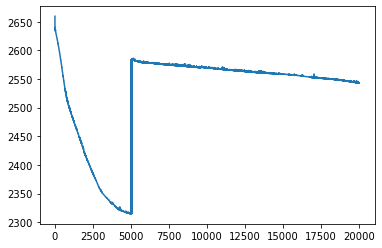

casos_Bariloche.txt
primer sintoma de persona confirmada:  2020-03-09 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


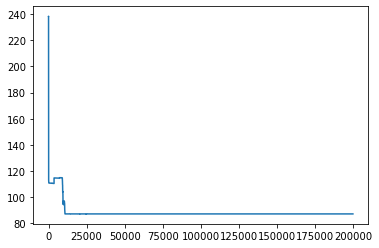

casos_Buenos Aires.txt
primer sintoma de persona confirmada:  2020-01-02 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


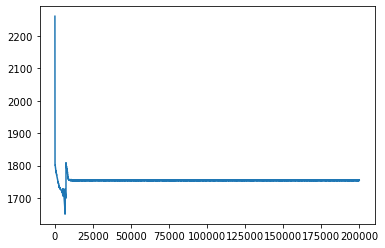

casos_CABA.txt
primer sintoma de persona confirmada:  2020-01-06 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


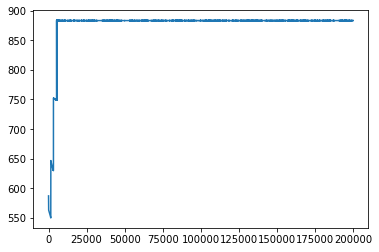

casos_Catamarca.txt
primer sintoma de persona confirmada:  2020-01-20 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


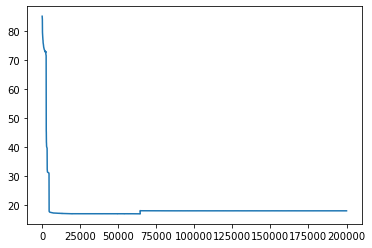

casos_Chaco.txt
primer sintoma de persona confirmada:  2020-03-01 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


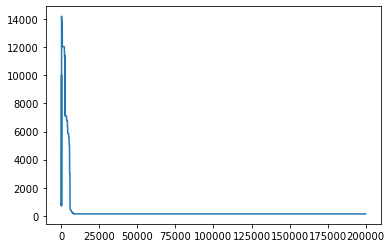

casos_Chubut.txt
primer sintoma de persona confirmada:  2020-01-21 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


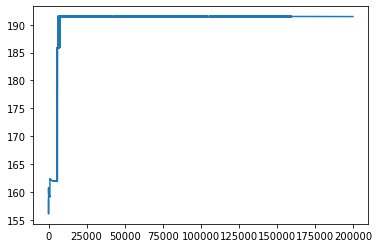

casos_Corrientes.txt
primer sintoma de persona confirmada:  2020-03-09 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


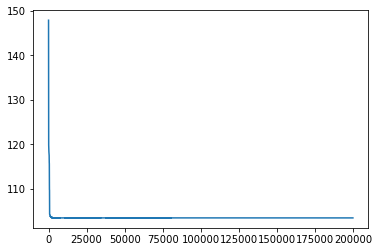

casos_Córdoba.txt
primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


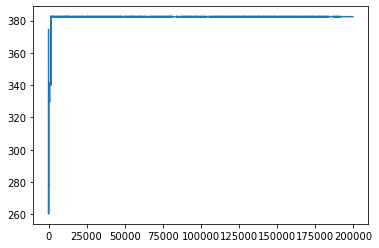

casos_Entre Ríos.txt
primer sintoma de persona confirmada:  2020-01-21 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


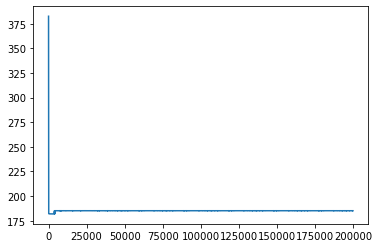

casos_Formosa.txt
primer sintoma de persona confirmada:  2020-06-10 00:00:00
ultimo sintoma de persona confirmada:  2020-12-22 00:00:00
ultima apertura de persona confirmada:  2020-12-28 00:00:00


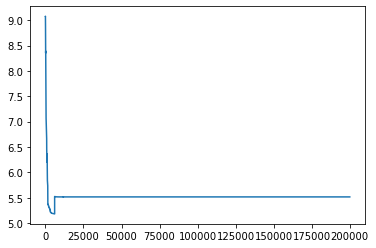

casos_Jujuy.txt
primer sintoma de persona confirmada:  2020-02-18 00:00:00
ultimo sintoma de persona confirmada:  2020-12-26 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


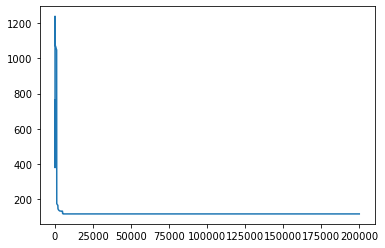

casos_La Pampa.txt
primer sintoma de persona confirmada:  2020-03-18 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


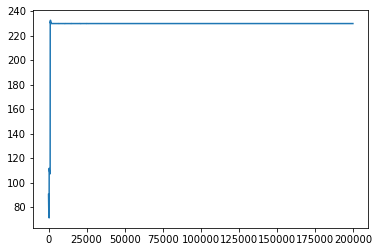

casos_La Rioja.txt
primer sintoma de persona confirmada:  2020-02-09 00:00:00
ultimo sintoma de persona confirmada:  2020-12-23 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


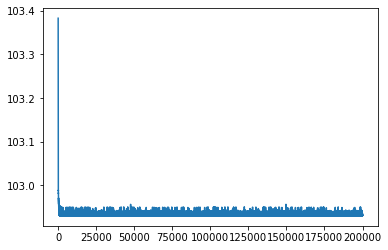

casos_Mendoza.txt
primer sintoma de persona confirmada:  2020-02-11 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


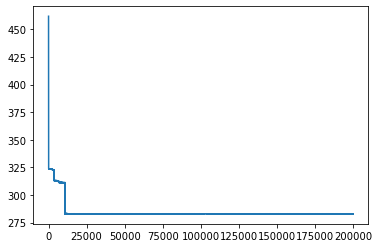

casos_Misiones.txt
primer sintoma de persona confirmada:  2020-03-21 00:00:00
ultimo sintoma de persona confirmada:  2020-12-24 00:00:00
ultima apertura de persona confirmada:  2020-12-28 00:00:00


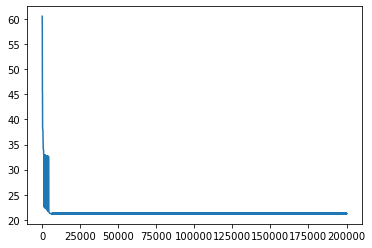

casos_Neuquén.txt
primer sintoma de persona confirmada:  2020-01-22 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


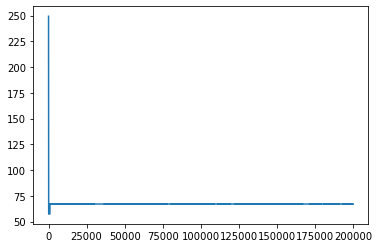

casos_Río Negro.txt
primer sintoma de persona confirmada:  2020-01-03 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


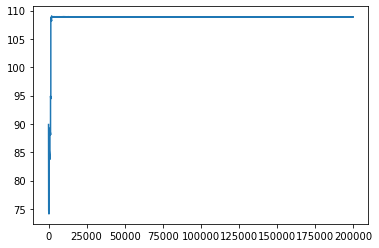

casos_Salta.txt
primer sintoma de persona confirmada:  2020-02-18 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


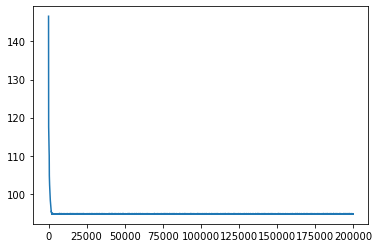

casos_San Juan.txt
primer sintoma de persona confirmada:  2020-03-24 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


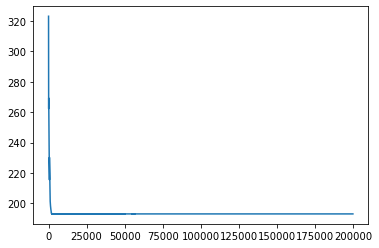

casos_San Luis.txt
primer sintoma de persona confirmada:  2020-03-06 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


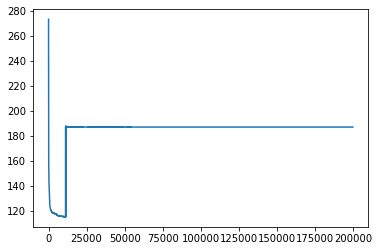

casos_Santa Cruz.txt
primer sintoma de persona confirmada:  2020-02-29 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


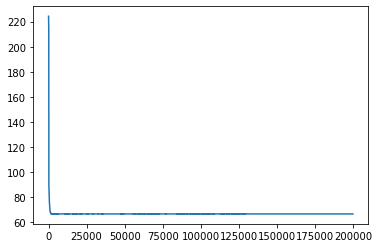

casos_Santa Fe.txt
primer sintoma de persona confirmada:  2020-02-19 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


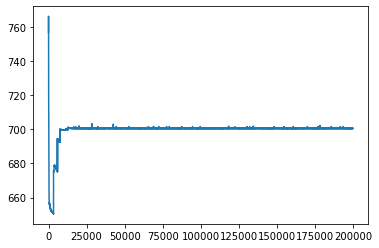

casos_Santiago del Estero.txt
primer sintoma de persona confirmada:  2020-01-11 00:00:00
ultimo sintoma de persona confirmada:  2020-12-28 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


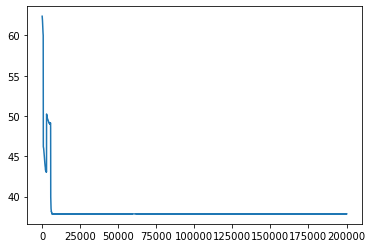

casos_Tierra del Fuego.txt
primer sintoma de persona confirmada:  2020-01-02 00:00:00
ultimo sintoma de persona confirmada:  2020-12-26 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


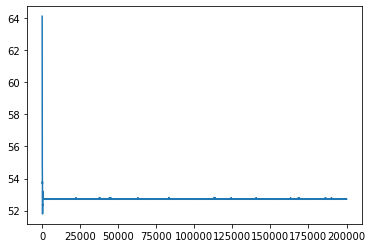

casos_Tucumán.txt
primer sintoma de persona confirmada:  2020-03-06 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


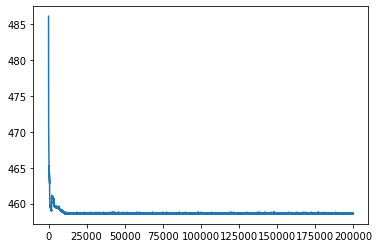

In [12]:
for file in files:
    print(file)
    data = pd.read_csv(str(mypath)+'/'+file,sep=",",quotechar='"',
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=[''])
    df = pd.DataFrame(data) 
    filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
    inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
    ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
    ultima_actualizacion_apertura = max(df["fecha_apertura"])
    df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
    df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
    df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
    df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
    change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
    print("primer sintoma de persona confirmada: ",inicio_epidemia)
    print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
    print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)
    fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
    fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
    fecha_sintomas = fecha_sintomas.astype(int)
    fecha_sintomas[fecha_sintomas < 0] = 0
    a = np.zeros(6) + 1
    pop = 100000
    rep_fun = repratio_t_conv
    r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
    a_t = a_t[13:]
    a_t[a_t.shape[0]-7:] = 0
    a = np.zeros(a_t.shape[0]+10)
    a[:a_t.shape[0]] = a_t
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_por_dia = sum_last14(casos_por_dia)
    casos_por_dia = casos_por_dia[20:,1]
    b = np.zeros(a_t.shape[0]+10)
    b[:casos_por_dia.shape[0]] = casos_por_dia
    b = b.reshape(b.shape[0],1)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia)
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    dias = np.copy(n_t[:,0]).astype(int)
    dias = dias[:-1]
    m1 = np.zeros((dias[dias>=6].shape[0],3)) #denominator of r7 expression
    m2 = np.zeros((dias[dias>=6].shape[0],3)) #numerator of r7 expression
    for i in dias[dias>=6]:
        m1[i-6,:] = n_t[i-6:i-3,1]
        m2[i-6,:] = n_t[i-1:i+2,1]
    def my_matrix(shape):
        m = np.zeros((shape,shape))
        i = 3
        while i < shape-3:
            m[i,i-3:i+4] = 1/7
            i = i + 1
        return m
    m1 = m1[:250,:]
    m2 = m2[:250,:]
    n_dias = m1.shape[0]
    a = a[:250]
    b = b[:250]
    numpyA = my_matrix(n_dias)
    numpyA = keras.backend.variable(numpyA)
    mat = numpyA
    if file == 'CasosCovid19_arg.txt':
        input_1 = keras.layers.Input(shape=(3,))
        input_2 = keras.layers.Input(shape=(3,))
        input_3 = keras.layers.Input(shape=(1,))
        initializer = keras.initializers.Ones() #the vector of weights a
        l_input_1 = keras.layers.Dense(1,activation='relu',kernel_initializer=initializer,use_bias=False)(input_1)
        l_input_2 = keras.layers.Dense(1,activation='relu',use_bias=False,kernel_initializer=initializer,trainable=False)(input_2)
        division = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] != 0, tf.math.minimum(inputs[1]/inputs[0],4), inputs[1]))([l_input_1, l_input_2])#calculates empirical rt
        mean = keras.layers.Lambda(lambda x: keras.backend.dot(mat,x))(division) #calculates mean r_seven in seven days
        cases = keras.layers.Multiply()([input_3,mean]) #cases for valid prediction,net output, padded with zeros at the end
        model = keras.Model(inputs=[input_1,input_2,input_3],outputs=[cases])
        optimizer = keras.optimizers.Adam(5e-3)
        model.compile(optimizer, loss=mse_custom)
        history = model.fit([m1,m2,a*(100000/pop)], b*(100000/pop), epochs=20000, batch_size=n_dias,shuffle=False)
        model.save('my_model.h5')
    else:
        model = load_model('my_model.h5', custom_objects={'tf': tf,'keras':keras,'mat':mat,'mse_custom':mse_custom})
        history = model.fit([m1,m2,a], b, epochs=200000, batch_size=n_dias,verbose=0,shuffle=False)
        model.save('my_model.h5')
    plt.plot(history.history['loss'])
    plt.show()

In [13]:
first_layer_weights = model.layers[2].get_weights()
second_layer_weights = model.layers[3].get_weights()
print(first_layer_weights,second_layer_weights)

[array([[ 0.4051861],
       [-1.2436757],
       [ 4.042809 ]], dtype=float32)] [array([[1.],
       [1.],
       [1.]], dtype=float32)]
